In [1]:
# Set the experiment name to be something meaningful. 
# It will be part of the name of the model to be saved.
EXPERIMENT_NAME = "[HashNet-100-iteration]"
DEBUG = True        # Set to True if you want to see outputs used for debugging 
verbose = False      # Set to True if you want to see the loss function per epoch in real time

In [2]:
from IPython.display import SVG

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Input, Concatenate, Layer
from keras.applications import vgg19
from keras.utils import plot_model
from keras.optimizers import RMSprop, Adam
from keras import backend as K
from keras.utils.vis_utils import model_to_dot

import sys
import datetime
import keras
import pickle
import logging
import h5py
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy import ndimage
import scipy.io

from songdb import data_dict
from preprocess import preprocess
from model import build_model

%matplotlib inline

/home/mjenrungrot/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/mjenrungrot/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
logger = logging.getLogger()

# File Handler
fhandler = logging.FileHandler(filename='{:}.log'.format(EXPERIMENT_NAME), mode='w')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)

# Output stream Handler
ch = logging.StreamHandler(sys.stdout)
ch.setFormatter(formatter)
logger.addHandler(ch)

if DEBUG: 
    logger.setLevel(logging.DEBUG)
    ch.setLevel(logging.DEBUG)
else:     
    logger.setLeveL(logging.INFO)
    ch.setLevel(logging.INFO)

## Config Keras

In this code, we will use tensorflow backend on Keras because it's relatively faster than Theano. We'll use the image data format in the form of `(n_channel, width, height)`. Please look at the Keras documentation for more details.

In [4]:
assert K.backend() == 'tensorflow'
logger.debug("Keras backend is tensorflow.")

K.set_image_data_format('channels_first')
assert K.image_data_format() == 'channels_first'
logger.debug("Keras image data format is channels_first")

2018-03-06 21:07:30,044 - root - DEBUG - Keras backend is tensorflow.
2018-03-06 21:07:30,049 - root - DEBUG - Keras image data format is channels_first


## Load dataset
We load the pair-annotation dataset. Here, we generate an array of of shapes `(n_pairs, 2, 76, 121)`.

In [5]:
logger.debug("Load Paired-annotation data")
data = data_dict()
logger.debug("\t data.type = {:}".format(type(data)))
logger.debug("\t data = {:}".format(data))
ref_query_pairs = data['taylorswift']

songPairs = []
totalPairs = 0 
for ref, query in ref_query_pairs:
    # Get pairs for each ref + query
    curr_pairs = []
    for i in range(ref.shape[0]):
        refQ = preprocess(librosa.cqt(np.asfarray(ref[i], dtype='float32'), sr = 22050, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96), 3).T
        queryQ = preprocess(librosa.cqt(np.asfarray(query[i], dtype='float32'), sr = 22050, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96), 3).T
        Q_pair = np.append(np.array([refQ]), np.array([queryQ]), axis=0)[np.newaxis, :]
        curr_pairs.append(Q_pair)
    curr_pairs = np.vstack(tuple(curr_pairs))
    totalPairs += curr_pairs.shape[0]
    songPairs.append(curr_pairs)
    logger.debug("Song {:}: Finish current pairs with shape = {:}".format(len(songPairs), curr_pairs.shape))
    logger.debug("Number of samples for the current song: {:}".format(len(curr_pairs)))

logger.debug("There are {:} number of pairs".format(totalPairs))

2018-03-06 21:07:30,121 - root - DEBUG - Load Paired-annotation data
2018-03-06 21:07:30,125 - root - DEBUG - 	 data.type = <class 'dict'>
2018-03-06 21:07:30,130 - root - DEBUG - 	 data = {'taylorswift': <generator object get_ref_query_pairs at 0x7f19b820c1a8>}


/home/mjenrungrot/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):
/home/mjenrungrot/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):
/home/mjenrungrot/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.d

2018-03-06 21:07:50,301 - root - DEBUG - Song 1: Finish current pairs with shape = (272, 2, 76, 121)
2018-03-06 21:07:50,304 - root - DEBUG - Number of samples for the current song: 272
2018-03-06 21:08:09,667 - root - DEBUG - Song 2: Finish current pairs with shape = (264, 2, 76, 121)
2018-03-06 21:08:09,669 - root - DEBUG - Number of samples for the current song: 264
2018-03-06 21:08:16,963 - root - DEBUG - Song 3: Finish current pairs with shape = (100, 2, 76, 121)
2018-03-06 21:08:16,965 - root - DEBUG - Number of samples for the current song: 100
2018-03-06 21:08:24,243 - root - DEBUG - Song 4: Finish current pairs with shape = (100, 2, 76, 121)
2018-03-06 21:08:24,245 - root - DEBUG - Number of samples for the current song: 100
2018-03-06 21:08:40,642 - root - DEBUG - Song 5: Finish current pairs with shape = (221, 2, 76, 121)
2018-03-06 21:08:40,644 - root - DEBUG - Number of samples for the current song: 221
2018-03-06 21:08:59,122 - root - DEBUG - Song 6: Finish current pairs 

In [6]:
p_train = .6
cutOffIdx = 0
currentNumberOfPairs = 0
for song in songPairs:
    currentNumberOfPairs += song.shape[0]
    cutOffIdx += 1
    if currentNumberOfPairs >= totalPairs * p_train:
        break

data_train = tuple(songPairs[:cutOffIdx])
data_val = tuple(songPairs[cutOffIdx:])
logger.debug("Finish loading paired-annotation data")
logger.debug("=> There are {:} songs for training [{:.2f} percent]".format(len(data_train), (currentNumberOfPairs/totalPairs * 100.0)))
logger.debug("=> There are {:} songs for validation".format(len(data_val)))

2018-03-06 21:09:30,173 - root - DEBUG - Finish loading paired-annotation data
2018-03-06 21:09:30,174 - root - DEBUG - => There are 6 songs for training [74.05 percent]
2018-03-06 21:09:30,175 - root - DEBUG - => There are 2 songs for validation


## Preprocessing
Obtain a matrix $X_1$, $X_2$, $[w_{ij}]$, and $[s_{ij}]$ where $X_1$ and $X_2$ are pairs of images of shape 
`(n_samples, 1, width, height)`; $[w_{ij}]$ is the weight vector of shape `(n_samples, 1)` which describes the weight of each pair; and $[s_{ij}]$ is a binary vector of shape `(n_samples,1)` indicating whether inputs $i$ and $j$ are the same.

__Add similar pairs__

We add similar pairs based on the dataset we have.

__Add non-similar pairs__

We add non-similar pairs by randomly selecting two CQT frames from the dataset. Note that we say two CQT pairs are not similar when they come from different songs only.

__Data Post-processing__

Convert $X_1$, $X_2$, $[s_{ij}]$ in to numpy arrays.

__Calculate weights__

Calculate the weight vector $[w_{ij}]$. The term $w_{ij}$ is defined as 

$$
    w_{ij} = \begin{cases}
    \frac{|S|}{|S_{1}|} &\text{if $x^{(i)}$ is similar to $x^{(j)}$}\\
    \frac{|S|}{|S_{0}|} &\text{if $x^{(i)}$ is not similar to $x^{(j)}$}
    \end{cases}
$$

In [7]:
def generate_training_data(data, nNonSimilar=1000):
#     nPairs = data.shape[0] 
    X1 = []
    X2 = []
    S = []
    groundTruth = []
    
    # add similar pairs
    for songId in range(len(data)):
        nPairs = data[songId].shape[0]
        for idx in range(nPairs):
            X1.append(np.expand_dims(data[songId][idx][0][:][:], axis=0))
            X2.append(np.expand_dims(data[songId][idx][1][:][:], axis=0))
            groundTruth.append(((songId,idx),(songId,idx)))
            S.append(True)
        
    # add non-similar pairs
    for i in range(nNonSimilar):
        [songId1, songId2] = np.random.choice(len(data), 2, replace=False)
        nPairs1 = data[songId1].shape[0]
        nPairs2 = data[songId2].shape[0]

        [idx1] = np.random.choice(nPairs1, 1)
        [idx2] = np.random.choice(nPairs2, 1)
        X1.append(np.expand_dims(data[songId1][idx1][0][:][:], axis=0))
        X2.append(np.expand_dims(data[songId2][idx2][1][:][:], axis=0))
        S.append((songId1,idx1) == (songId2,idx2))
        groundTruth.append(((songId1,idx1),(songId2,idx2)))
        
    # post-processing
    X1 = np.array(X1)
    X2 = np.array(X2)
    S = np.array(S).reshape(-1,1)
    # calculate weights
    n_sim = len(S[S==True])
    w_sim   = len(X1) / n_sim             # w_ij for similar pairs
    w_insim = len(X1) / (len(X1) - n_sim)  # w_ij for dissimilar pairs
    W = S*w_sim + (~S)*w_insim          # w vector for pairs
    S = S.astype('float32')
    
    logger.debug("X1 shape: {:}".format(X1.shape))
    logger.debug("X2 shape: {:}".format(X2.shape))
    logger.debug("S shape: {:}".format(S.shape))
    logger.debug("W shape: {:}".format(W.shape))
    logger.debug("There are {:} out of {:} pairs that are similar [{:.2f} percent]".format(n_sim, 
                                                                                           len(X1),
                                                                                           100.0*n_sim/len(X1)))
    
    return X1, X2, S, W, groundTruth

In [8]:
X1, X2, S, W, groundTruth = generate_training_data(data_train)
X1_val, X2_val, S_val, W_val, groundTruth_val = generate_training_data(data_val)

2018-03-06 21:09:30,500 - root - DEBUG - X1 shape: (2210, 1, 76, 121)
2018-03-06 21:09:30,501 - root - DEBUG - X2 shape: (2210, 1, 76, 121)
2018-03-06 21:09:30,502 - root - DEBUG - S shape: (2210, 1)
2018-03-06 21:09:30,502 - root - DEBUG - W shape: (2210, 1)
2018-03-06 21:09:30,503 - root - DEBUG - There are 1210 out of 2210 pairs that are similar [54.75 percent]
2018-03-06 21:09:30,645 - root - DEBUG - X1 shape: (1424, 1, 76, 121)
2018-03-06 21:09:30,647 - root - DEBUG - X2 shape: (1424, 1, 76, 121)
2018-03-06 21:09:30,647 - root - DEBUG - S shape: (1424, 1)
2018-03-06 21:09:30,648 - root - DEBUG - W shape: (1424, 1)
2018-03-06 21:09:30,649 - root - DEBUG - There are 424 out of 1424 pairs that are similar [29.78 percent]


In [9]:
nPairs = X1.shape[0]

## Model

__Define inputs__

Create a HashNet model with four inputs: two images tensors, similarity vector, and weight vector.

In [10]:
width = 76
height = 121
n_channel = 1

In [11]:
image_a    = Input(shape=(n_channel, width, height), name='image_1')
image_b    = Input(shape=(n_channel, width, height), name='image_2')
similarity = Input(shape=(1,), name="similarity")
weight     = Input(shape=(1,), name="weight")

__Pre-trained model__

Use a pre-trained model here to obtain intermediate values from the pre-trained model. We call this pre-trained model by `base_model`. The `base_model` is generally used to convert a CQT image to some representation.

In [12]:
model_path = '/data1/mint/public/taylorswift_out/model.mat'
model = scipy.io.loadmat(model_path)
logger.debug("Load model from {:}".format(model_path))
evecs = np.array(model['eigvecs']).T

2018-03-06 21:09:31,190 - root - DEBUG - Load model from /data1/mint/public/taylorswift_out/model.mat


In [13]:
m = 20
pca_matrix = np.array([vec.reshape((m, -1)) for vec in evecs])
delta = 4
base_model = build_model(pca_matrix, refQ.shape, delta=delta, compute_delta=True)
logger.debug("Construct base model")

2018-03-06 21:09:32,625 - root - DEBUG - Construct base model


In [14]:
# pop last layer
lastLayer = base_model.layers[-1]
base_model.pop()

# add dropout
base_model.add(Dropout(0.3)) # Drop 30%

# add back the last layer
base_model.add(lastLayer)

# add dropout
base_model.add(Dropout(0.3)) # Drop 30%

2018-03-06 21:09:32,900 - root - DEBUG - Save base_model architecture to base_model.png


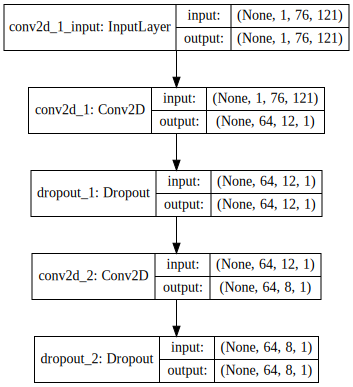

In [15]:
plot_model(base_model, show_shapes=True, to_file='base_model.png')
logger.debug("Save base_model architecture to base_model.png")
SVG(model_to_dot(base_model, show_shapes=True).create(prog='dot', format='svg'))

__Obtain intermediate values__

Intermediate values are values directly after the base model.

In [16]:
# Obtain intermediate tensor
intermediate_a = base_model(image_a)
intermediate_b = base_model(image_b)

# Flatten the layer
flatten_a = Flatten()(intermediate_a)
flatten_b = Flatten()(intermediate_b)

__Append a layer for binary encoding__

This layer has a `tanh` activation defined in the same way as HashNet paper. Note that initial beta value, number of bits, and `alpha` in the block below are hyperparameters.

In [17]:
beta         = 1            # Initial beta value
numberOfBits = None
alpha        = 0.05         # Set to be something small because it prevents the loss function from blowing up.
logger.debug("[HashNet Model] beta = {:}, numberOfBits = {:}, alpha = {:}".format(beta, numberOfBits, alpha))

2018-03-06 21:09:33,366 - root - DEBUG - [HashNet Model] beta = 1, numberOfBits = None, alpha = 0.05


In [18]:
def custom_activation(x):
    """
    Our own defined activation function
    """
    global beta
    return K.tanh(beta * x)

In [19]:
class CustomizedLossLayer(Layer):
    """
    Our own defined layer for keeping track of loss function
    """
    
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomizedLossLayer, self).__init__(**kwargs)
    
    def my_loss(self, encoded_a, encoded_b, similarity, weight):
        global alpha
        x = encoded_a
        y = encoded_b
        dot_product = K.sum(x * y, axis=-1, keepdims=True)
        logger.debug(dot_product)
        return K.sum(weight * (K.log(1 + K.exp(alpha * dot_product)) - alpha * similarity * dot_product))
    
    def call(self, inputs):
        encoded_a = inputs[0]
        encoded_b = inputs[1]
        similarity = inputs[2]
        weight = inputs[3]
        loss = self.my_loss(encoded_a, encoded_b, similarity, weight)
        self.add_loss(loss, inputs=inputs)
        return K.ones_like(similarity)


In [20]:
activation_layer = Activation(custom_activation)
encoded_a = activation_layer(flatten_a)
encoded_b = activation_layer(flatten_b)

__Create a model for training__

We construct a model using 2 representations derived by the same base model and similarity and weight. The architecture of the model is given below.

In [21]:
# Define a loss layer with 4 inputs
loss = CustomizedLossLayer()([encoded_a, encoded_b, similarity, weight])

2018-03-06 21:09:33,428 - root - DEBUG - Tensor("customized_loss_layer_1/Sum:0", shape=(?, 1), dtype=float32)


In [22]:
# Define a model that has 4 inputs and outputs loss
model = Model(inputs=[image_a, image_b, similarity, weight], outputs=[loss])

In [23]:
# Compile the model with our own defined loss function.
# Note that loss function is already defined in a layer, so
# `zero_loss` here doesn't actually do anything.

def zero_loss(y_true, y_pred):
    return K.zeros_like(y_pred)

logger.debug("Use Adam optimizer with lr = 1e-5")
adam = Adam(lr=1e-5)
model.compile(optimizer=adam, loss=zero_loss)

2018-03-06 21:09:33,455 - root - DEBUG - Use Adam optimizer with lr = 1e-5


__Visualize model architecture__

2018-03-06 21:09:33,678 - root - DEBUG - Save model architecture to model.png


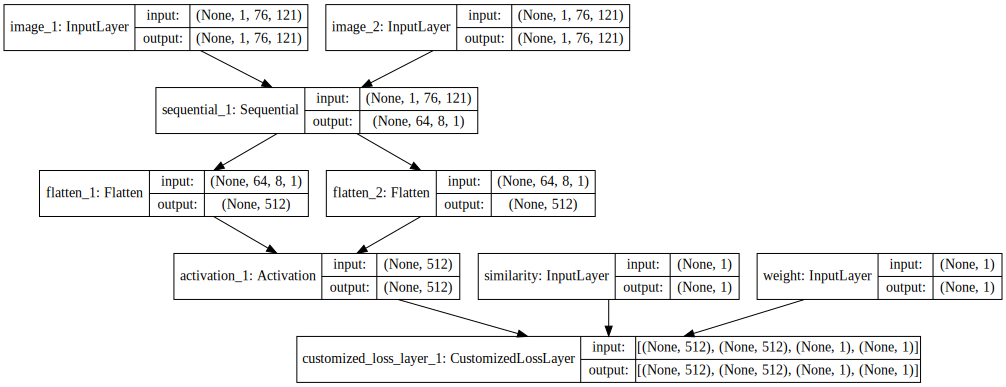

In [24]:
plot_model(model, show_shapes=True, to_file='model.png')
logger.debug("Save model architecture to model.png")
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Visualize performance before training

For the purpose of understanding the performance of this algorithm, we find the baseline result by computing the hamming distance between two representations before training and then plotting the corresponding histogram. Based on the above diagram, we use the representation at layers named `flatten_1` and `flatten_2`, before the fully connected layer defined by HashNet paper.

In [25]:
representation_model = Model(image_a, flatten_a)

In [26]:
def visualize(X1, X2, groundTruth, model):
    plt.figure()
    hist_sim = []
    hist_non_sim = []
    bins = np.linspace(0, 400, 100)

    pred_X1 = (model.predict(X1) > 0)
    pred_X2 = (model.predict(X2) > 0)
    for idx in range(len(X1)):
        score = np.count_nonzero(pred_X1[idx] != pred_X2[idx])
        similarity = (groundTruth[idx][0] == groundTruth[idx][1])

        if similarity:
            hist_sim.append(score)
        else:
            hist_non_sim.append(score)

    plt.ylim((0, 135))
    plt.ylabel("Count")
    plt.xlabel("$|x-y|$, e.g. Hamming distance")
    plt.hist(hist_sim, bins, alpha=0.5, label='Similar pairs', color='blue')
    plt.hist(hist_non_sim, bins, alpha=0.5, label='Non-similar pairs', color='orange')
    plt.legend()
    plt.show()

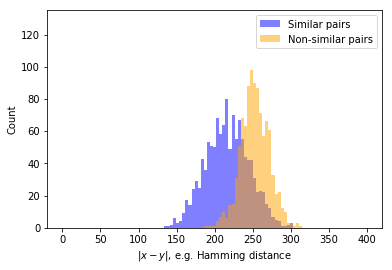

In [27]:
visualize(X1, X2, groundTruth, representation_model)

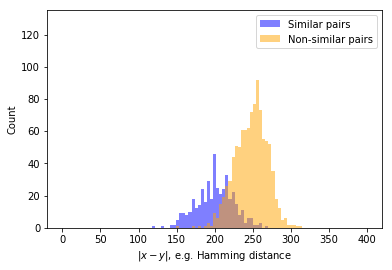

In [28]:
visualize(X1_val, X2_val, groundTruth_val, representation_model)

In [29]:
def visualizeFilters():
    nFilters = base_model.layers[0].get_weights()[0].shape[-1]
    plt.figure(figsize=(8,20))
    plt.tight_layout(pad=0, w_pad=0, h_pad=-10)
    for i in range(nFilters):
        filt = base_model.layers[0].get_weights()[0][:,:,0,i]
        plt.subplot(7, 10, i+1)
        plt.imshow(filt.T, cmap='jet')
        plt.xticks([])
        plt.yticks([])
    plt.show()

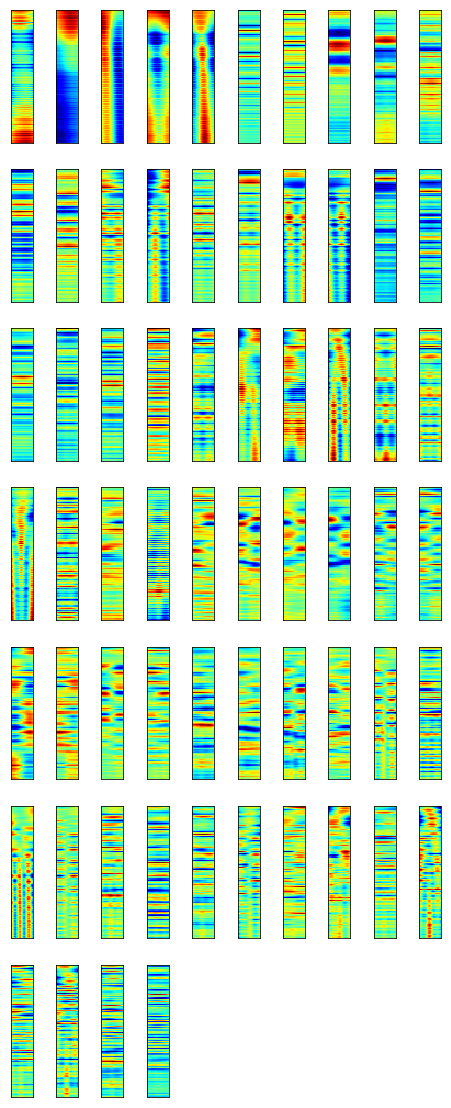

In [30]:
visualizeFilters()

## Train a model

In [31]:
# Check the input shape
logger.debug("Ready to train the model")
logger.debug("X1 shape: {:}".format(X1.shape))
logger.debug("X2 shape: {:}".format(X2.shape))
logger.debug("S shape: {:}".format(S.shape))
logger.debug("W shape: {:}".format(W.shape))

2018-03-06 21:09:39,167 - root - DEBUG - Ready to train the model
2018-03-06 21:09:39,169 - root - DEBUG - X1 shape: (2210, 1, 76, 121)
2018-03-06 21:09:39,170 - root - DEBUG - X2 shape: (2210, 1, 76, 121)
2018-03-06 21:09:39,171 - root - DEBUG - S shape: (2210, 1)
2018-03-06 21:09:39,172 - root - DEBUG - W shape: (2210, 1)


In [32]:
number_of_iterations = 100
logger.debug("[Training] number_of_iterations = {:}".format(number_of_iterations))
beta_factor = 4
logger.debug("[Training] beta_factor = {:}".format(beta_factor))
number_of_epochs = 200
logger.debug("[Training] number_of_epochs = {:}".format(number_of_epochs))

2018-03-06 21:09:39,191 - root - DEBUG - [Training] number_of_iterations = 100
2018-03-06 21:09:39,193 - root - DEBUG - [Training] beta_factor = 4
2018-03-06 21:09:39,194 - root - DEBUG - [Training] number_of_epochs = 200


In [33]:
train_losses = []
test_losses = []

2018-03-06 21:09:39,241 - root - DEBUG - Iteration 1 (current beta = 1)


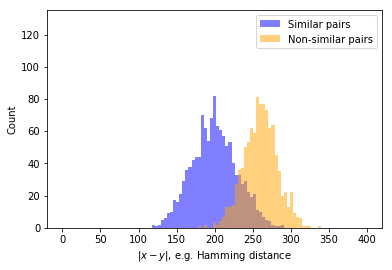

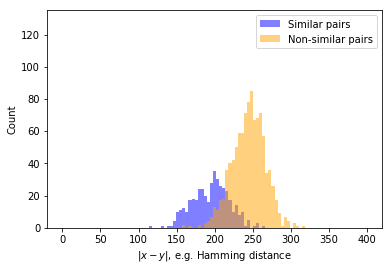

1424/1424 [==============================] - 0s 187us/step
2018-03-06 21:11:43,717 - root - DEBUG - [Iteration = 1] Training Loss = 32.06010753773996, Testing Loss = 52.74773795819014
2018-03-06 21:11:43,718 - root - DEBUG - Iteration 2 (current beta = 4)


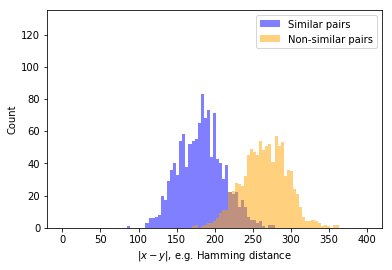

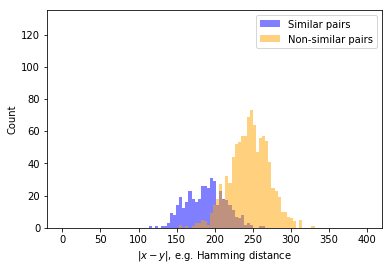

1424/1424 [==============================] - 0s 187us/step
2018-03-06 21:13:48,978 - root - DEBUG - [Iteration = 2] Training Loss = 31.476763253514044, Testing Loss = 54.02422276038802
2018-03-06 21:13:48,979 - root - DEBUG - Iteration 3 (current beta = 16)


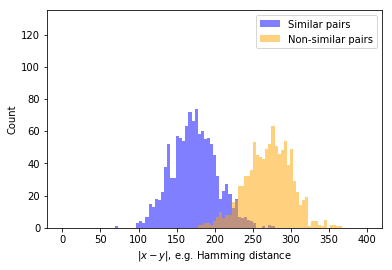

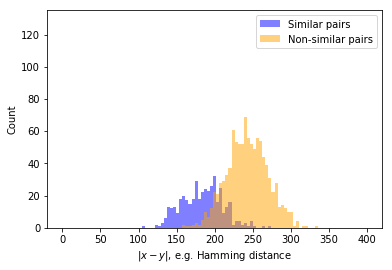

1424/1424 [==============================] - 0s 184us/step
2018-03-06 21:15:53,963 - root - DEBUG - [Iteration = 3] Training Loss = 26.234409021063627, Testing Loss = 61.660930514000775
2018-03-06 21:15:53,964 - root - DEBUG - Iteration 4 (current beta = 64)


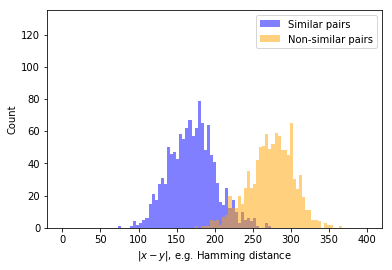

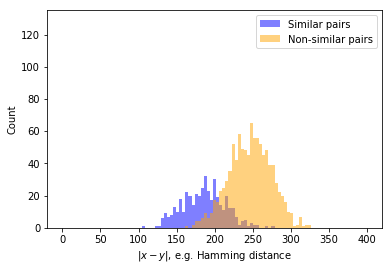

1424/1424 [==============================] - 0s 190us/step
2018-03-06 21:18:01,625 - root - DEBUG - [Iteration = 4] Training Loss = 22.587035580957096, Testing Loss = 56.21166591764836
2018-03-06 21:18:01,626 - root - DEBUG - Iteration 5 (current beta = 256)


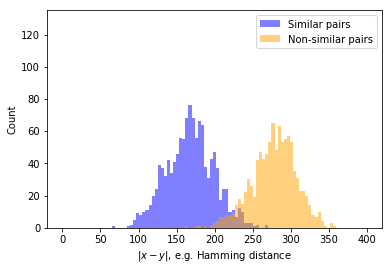

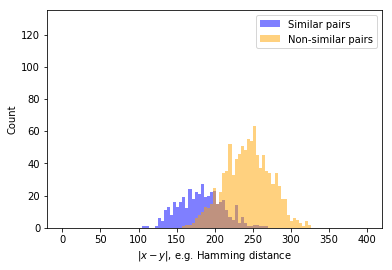

1424/1424 [==============================] - 0s 188us/step
2018-03-06 21:20:08,641 - root - DEBUG - [Iteration = 5] Training Loss = 19.801250863274163, Testing Loss = 64.83742138040199
2018-03-06 21:20:08,642 - root - DEBUG - Iteration 6 (current beta = 1024)


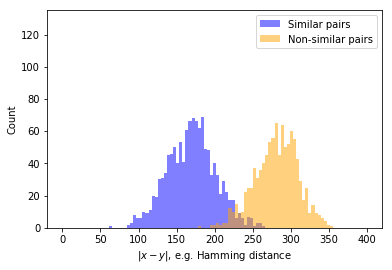

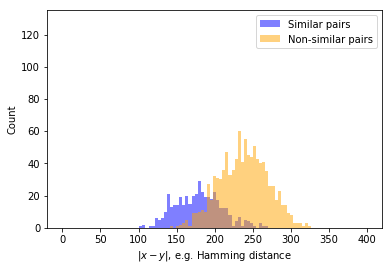

1424/1424 [==============================] - 0s 182us/step
2018-03-06 21:22:15,180 - root - DEBUG - [Iteration = 6] Training Loss = 16.79866047018119, Testing Loss = 76.92268544418758
2018-03-06 21:22:15,182 - root - DEBUG - Iteration 7 (current beta = 4096)


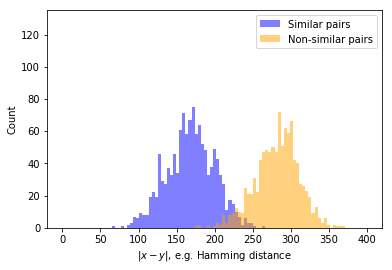

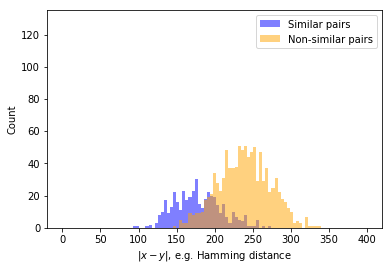

1424/1424 [==============================] - 0s 189us/step
2018-03-06 21:24:21,034 - root - DEBUG - [Iteration = 7] Training Loss = 15.332415596668806, Testing Loss = 77.61245983320006
2018-03-06 21:24:21,035 - root - DEBUG - Iteration 8 (current beta = 16384)


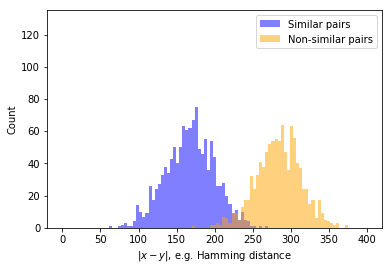

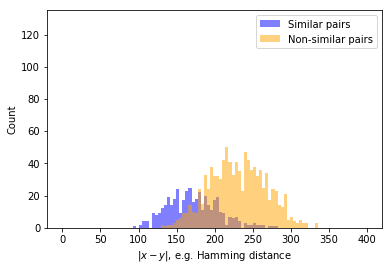

1424/1424 [==============================] - 0s 188us/step
2018-03-06 21:26:28,040 - root - DEBUG - [Iteration = 8] Training Loss = 14.565019541904668, Testing Loss = 99.87035193758902
2018-03-06 21:26:28,042 - root - DEBUG - Iteration 9 (current beta = 65536)


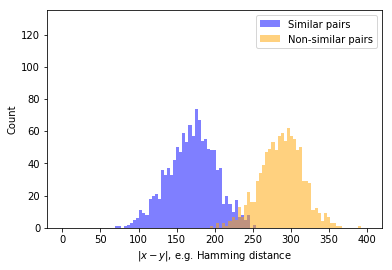

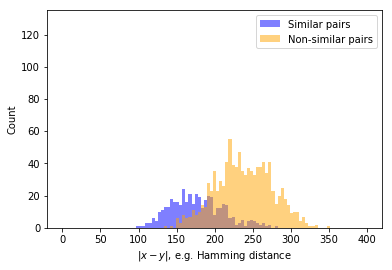

1424/1424 [==============================] - 0s 189us/step
2018-03-06 21:28:34,594 - root - DEBUG - [Iteration = 9] Training Loss = 11.094490022455, Testing Loss = 83.35291776412659
2018-03-06 21:28:34,595 - root - DEBUG - Iteration 10 (current beta = 262144)


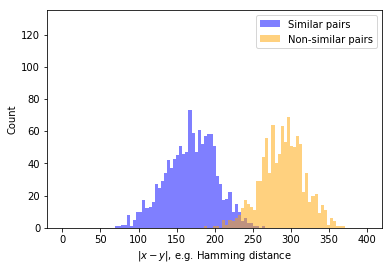

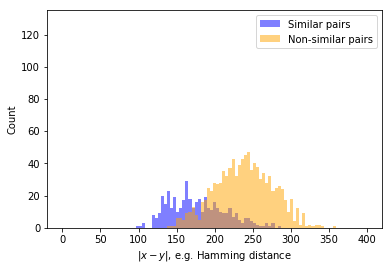

1424/1424 [==============================] - 0s 184us/step
2018-03-06 21:30:39,889 - root - DEBUG - [Iteration = 10] Training Loss = 10.537133751890508, Testing Loss = 83.94396437085076
2018-03-06 21:30:39,891 - root - DEBUG - Iteration 11 (current beta = 1048576)


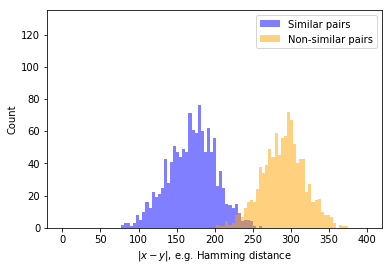

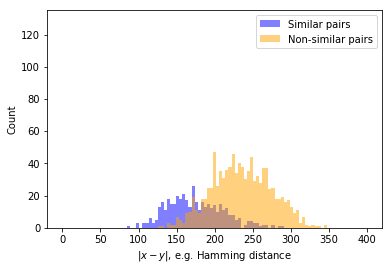

1424/1424 [==============================] - 0s 173us/step
2018-03-06 21:32:43,662 - root - DEBUG - [Iteration = 11] Training Loss = 9.574431542967915, Testing Loss = 92.09229583360171
2018-03-06 21:32:43,664 - root - DEBUG - Iteration 12 (current beta = 4194304)


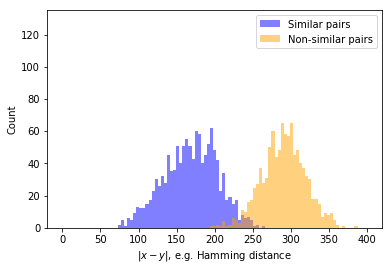

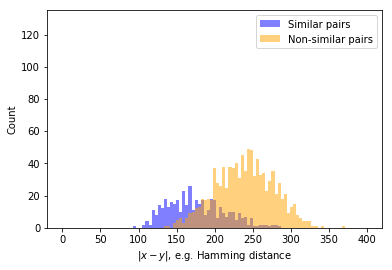

1424/1424 [==============================] - 0s 181us/step
2018-03-06 21:34:47,933 - root - DEBUG - [Iteration = 12] Training Loss = 10.147117458988504, Testing Loss = 83.78860652015618
2018-03-06 21:34:47,934 - root - DEBUG - Iteration 13 (current beta = 16777216)


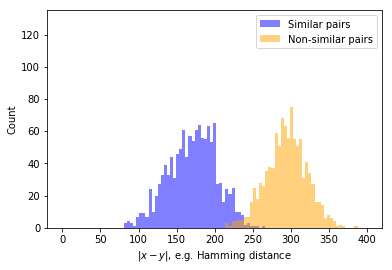

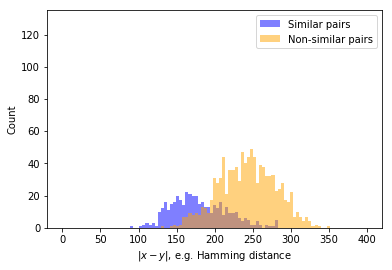

1424/1424 [==============================] - 0s 192us/step
2018-03-06 21:36:52,493 - root - DEBUG - [Iteration = 13] Training Loss = 7.121696229676855, Testing Loss = 75.56132357776835
2018-03-06 21:36:52,494 - root - DEBUG - Iteration 14 (current beta = 67108864)


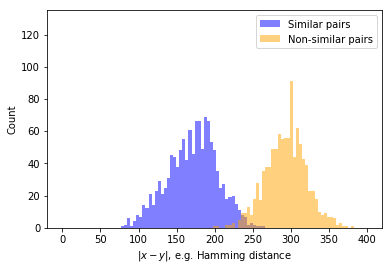

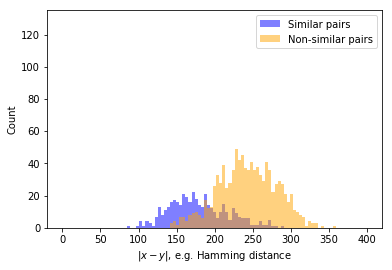

1424/1424 [==============================] - 0s 179us/step
2018-03-06 21:38:56,469 - root - DEBUG - [Iteration = 14] Training Loss = 7.358828273570645, Testing Loss = 77.0543618856856
2018-03-06 21:38:56,470 - root - DEBUG - Iteration 15 (current beta = 268435456)


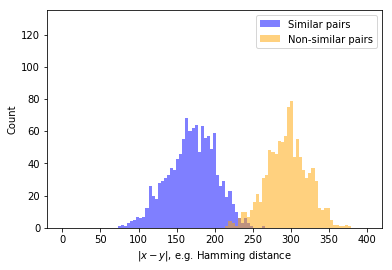

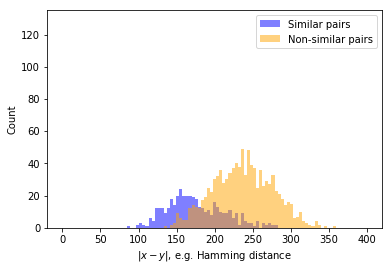

1424/1424 [==============================] - 0s 164us/step
2018-03-06 21:41:00,642 - root - DEBUG - [Iteration = 15] Training Loss = 6.708420092292231, Testing Loss = 89.5422315279838
2018-03-06 21:41:00,643 - root - DEBUG - Iteration 16 (current beta = 1073741824)


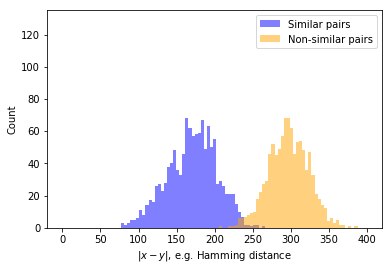

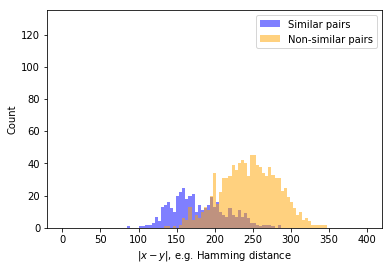

1424/1424 [==============================] - 0s 185us/step
2018-03-06 21:43:04,936 - root - DEBUG - [Iteration = 16] Training Loss = 5.729190493101988, Testing Loss = 70.92970558105225
2018-03-06 21:43:04,937 - root - DEBUG - Iteration 17 (current beta = 4294967296)


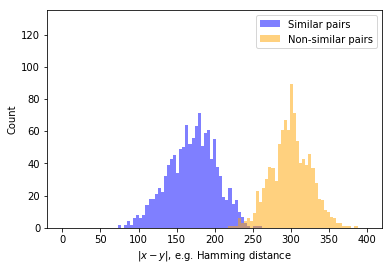

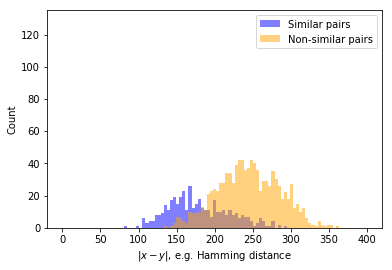

1424/1424 [==============================] - 0s 176us/step
2018-03-06 21:45:08,565 - root - DEBUG - [Iteration = 17] Training Loss = 4.634802664270229, Testing Loss = 78.34147220896034
2018-03-06 21:45:08,567 - root - DEBUG - Iteration 18 (current beta = 17179869184)


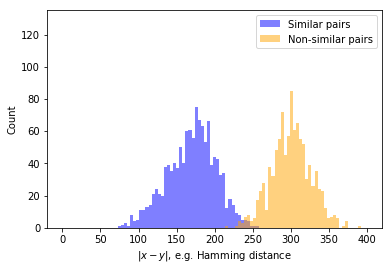

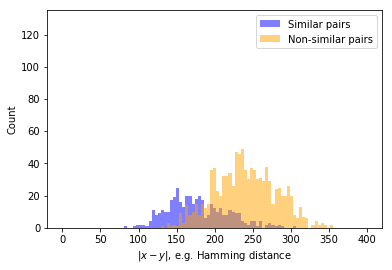

1424/1424 [==============================] - 0s 178us/step
2018-03-06 21:47:12,799 - root - DEBUG - [Iteration = 18] Training Loss = 4.348114738832502, Testing Loss = 85.3596059705518
2018-03-06 21:47:12,800 - root - DEBUG - Iteration 19 (current beta = 68719476736)


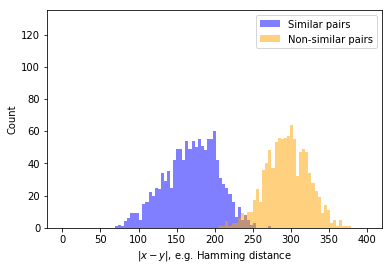

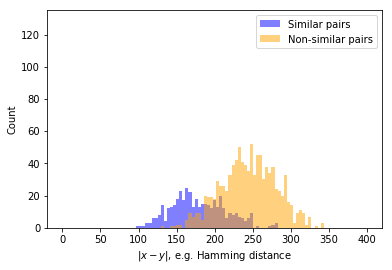

1424/1424 [==============================] - 0s 182us/step
2018-03-06 21:49:15,903 - root - DEBUG - [Iteration = 19] Training Loss = 7.1896079127857995, Testing Loss = 71.67724395467994
2018-03-06 21:49:15,904 - root - DEBUG - Iteration 20 (current beta = 274877906944)


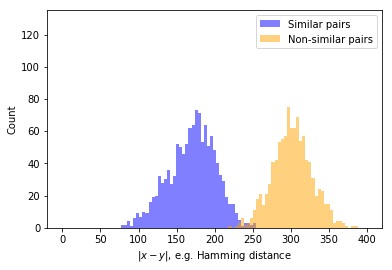

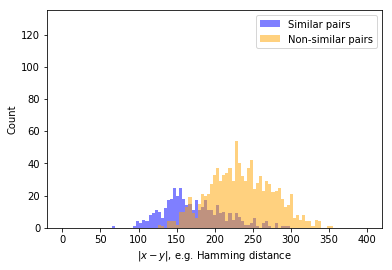

1424/1424 [==============================] - 0s 165us/step
2018-03-06 21:51:19,893 - root - DEBUG - [Iteration = 20] Training Loss = 3.9560815870357313, Testing Loss = 98.27285079936382
2018-03-06 21:51:19,894 - root - DEBUG - Iteration 21 (current beta = 1099511627776)


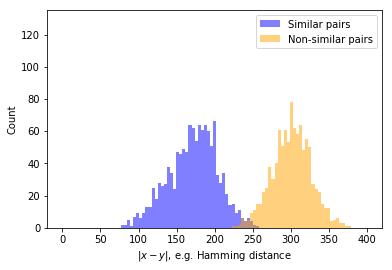

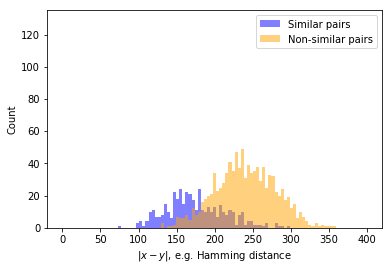

1424/1424 [==============================] - 0s 184us/step
2018-03-06 21:53:22,670 - root - DEBUG - [Iteration = 21] Training Loss = 4.25503370215046, Testing Loss = 84.96969971303524
2018-03-06 21:53:22,671 - root - DEBUG - Iteration 22 (current beta = 4398046511104)


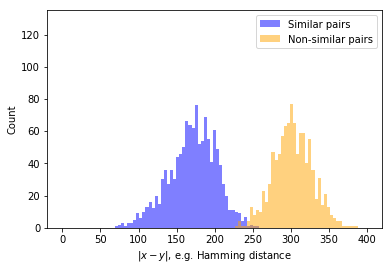

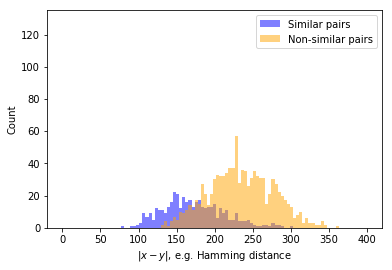

1424/1424 [==============================] - 0s 181us/step
2018-03-06 21:55:26,284 - root - DEBUG - [Iteration = 22] Training Loss = 3.4810823579314607, Testing Loss = 100.0259027090133
2018-03-06 21:55:26,286 - root - DEBUG - Iteration 23 (current beta = 17592186044416)


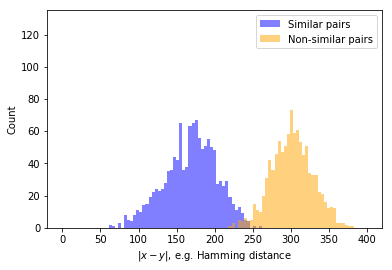

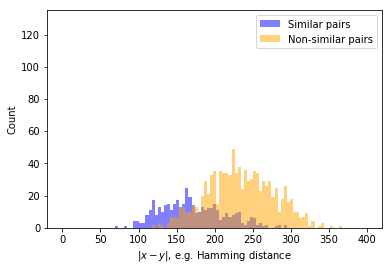

1424/1424 [==============================] - 0s 180us/step
2018-03-06 21:57:29,492 - root - DEBUG - [Iteration = 23] Training Loss = 4.410652001492038, Testing Loss = 101.8843701971339
2018-03-06 21:57:29,494 - root - DEBUG - Iteration 24 (current beta = 70368744177664)


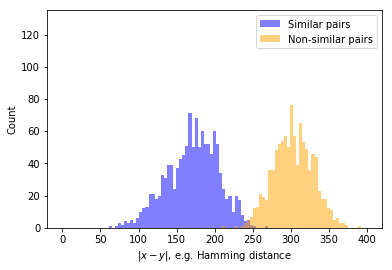

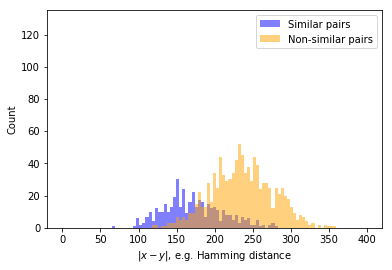

1424/1424 [==============================] - 0s 172us/step
2018-03-06 21:59:32,940 - root - DEBUG - [Iteration = 24] Training Loss = 3.5469269836953594, Testing Loss = 92.25770667442278
2018-03-06 21:59:32,942 - root - DEBUG - Iteration 25 (current beta = 281474976710656)


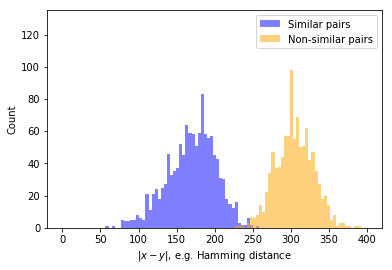

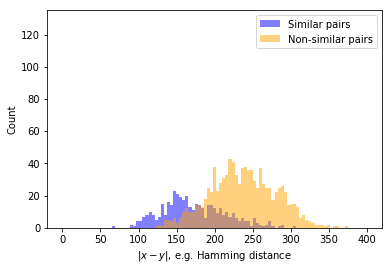

1424/1424 [==============================] - 0s 180us/step
2018-03-06 22:01:35,618 - root - DEBUG - [Iteration = 25] Training Loss = 2.779407395779817, Testing Loss = 95.22602873573896
2018-03-06 22:01:35,620 - root - DEBUG - Iteration 26 (current beta = 1125899906842624)


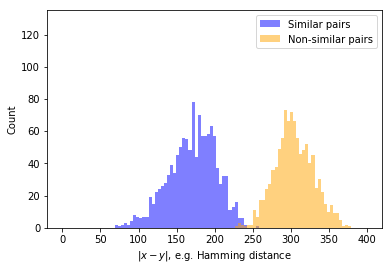

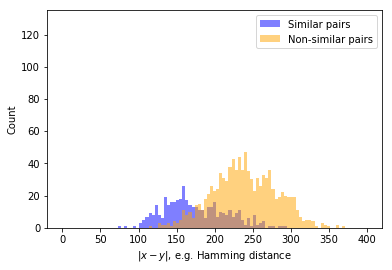

1424/1424 [==============================] - 0s 177us/step
2018-03-06 22:03:39,749 - root - DEBUG - [Iteration = 26] Training Loss = 2.8195255269865376, Testing Loss = 88.61437225266454
2018-03-06 22:03:39,750 - root - DEBUG - Iteration 27 (current beta = 4503599627370496)


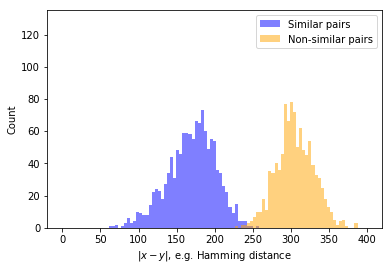

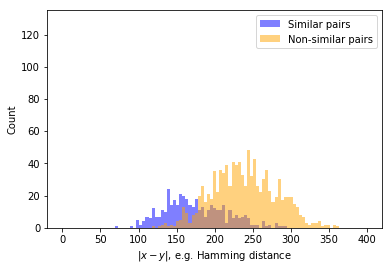

1424/1424 [==============================] - 0s 182us/step
2018-03-06 22:05:42,417 - root - DEBUG - [Iteration = 27] Training Loss = 2.637086653871234, Testing Loss = 90.75689225756888
2018-03-06 22:05:42,419 - root - DEBUG - Iteration 28 (current beta = 18014398509481984)


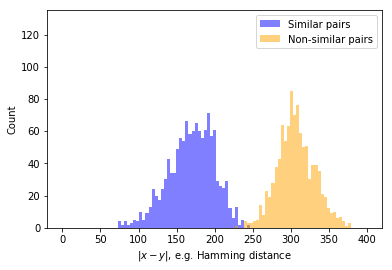

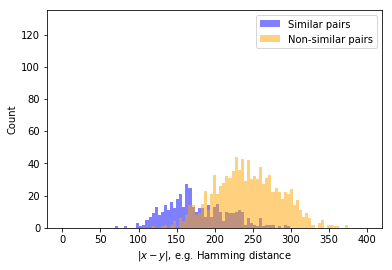

1424/1424 [==============================] - 0s 182us/step
2018-03-06 22:07:46,151 - root - DEBUG - [Iteration = 28] Training Loss = 2.2523186325892066, Testing Loss = 82.83749332509181
2018-03-06 22:07:46,152 - root - DEBUG - Iteration 29 (current beta = 72057594037927936)


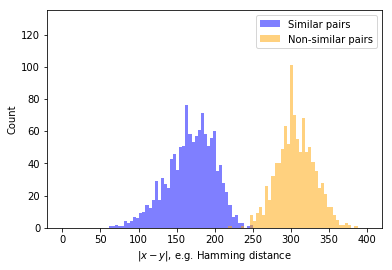

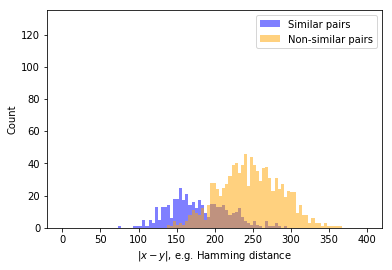

1424/1424 [==============================] - 0s 189us/step
2018-03-06 22:09:49,355 - root - DEBUG - [Iteration = 29] Training Loss = 2.207188232506023, Testing Loss = 73.01119499368949
2018-03-06 22:09:49,357 - root - DEBUG - Iteration 30 (current beta = 288230376151711744)


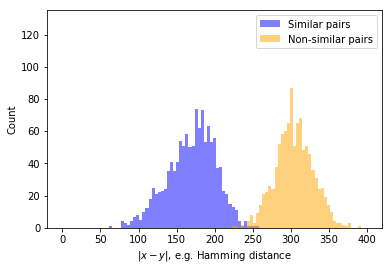

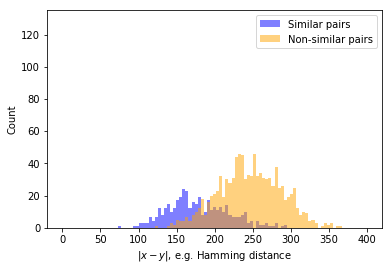

1424/1424 [==============================] - 0s 183us/step
2018-03-06 22:11:53,232 - root - DEBUG - [Iteration = 30] Training Loss = 2.7317496277627904, Testing Loss = 75.88267326421952
2018-03-06 22:11:53,233 - root - DEBUG - Iteration 31 (current beta = 1152921504606846976)


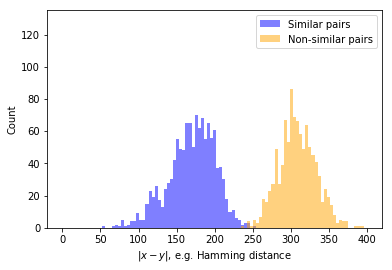

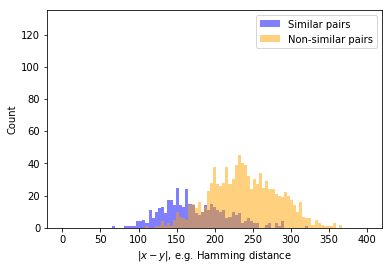

1424/1424 [==============================] - 0s 178us/step
2018-03-06 22:13:55,898 - root - DEBUG - [Iteration = 31] Training Loss = 1.8655044075287035, Testing Loss = 93.99477036468936
2018-03-06 22:13:55,899 - root - DEBUG - Iteration 32 (current beta = 4611686018427387904)


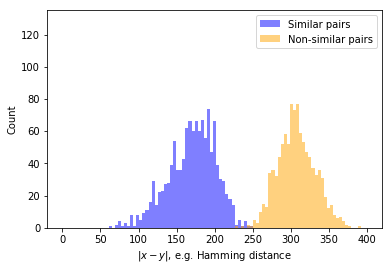

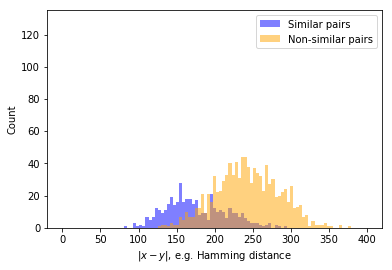

1424/1424 [==============================] - 0s 182us/step
2018-03-06 22:15:58,387 - root - DEBUG - [Iteration = 32] Training Loss = 1.8976882385941247, Testing Loss = 82.80051068978364
2018-03-06 22:15:58,389 - root - DEBUG - Iteration 33 (current beta = 18446744073709551616)


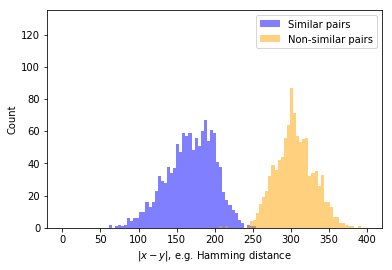

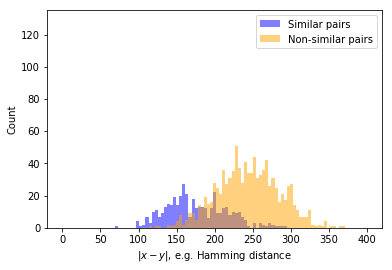

1424/1424 [==============================] - 0s 179us/step
2018-03-06 22:18:00,523 - root - DEBUG - [Iteration = 33] Training Loss = 2.469999455692609, Testing Loss = 78.72838229895308
2018-03-06 22:18:00,524 - root - DEBUG - Iteration 34 (current beta = 73786976294838206464)


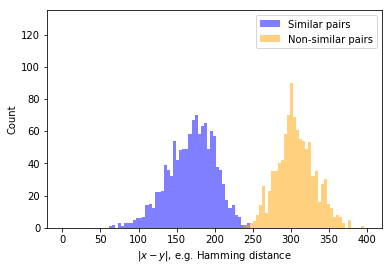

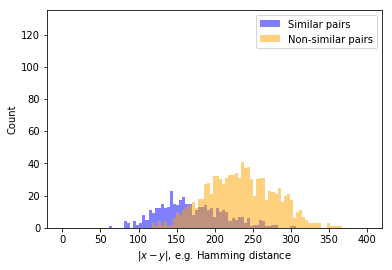

1424/1424 [==============================] - 0s 180us/step
2018-03-06 22:20:03,904 - root - DEBUG - [Iteration = 34] Training Loss = 2.143661168258115, Testing Loss = 103.78676064844045
2018-03-06 22:20:03,905 - root - DEBUG - Iteration 35 (current beta = 295147905179352825856)


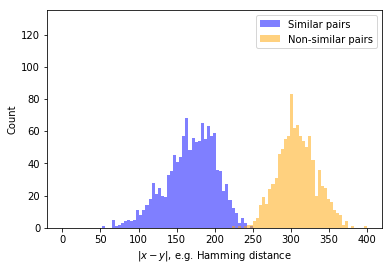

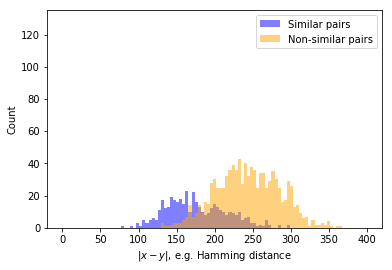

1424/1424 [==============================] - 0s 179us/step
2018-03-06 22:22:06,702 - root - DEBUG - [Iteration = 35] Training Loss = 2.0040448202806362, Testing Loss = 81.05722354323174
2018-03-06 22:22:06,703 - root - DEBUG - Iteration 36 (current beta = 1180591620717411303424)


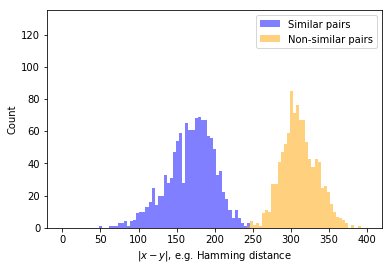

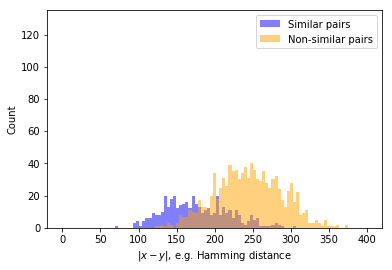

1424/1424 [==============================] - 0s 179us/step
2018-03-06 22:24:08,775 - root - DEBUG - [Iteration = 36] Training Loss = 1.2995739596866374, Testing Loss = 82.24219373772654
2018-03-06 22:24:08,777 - root - DEBUG - Iteration 37 (current beta = 4722366482869645213696)


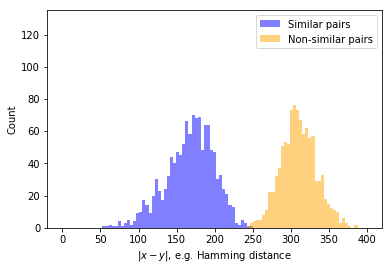

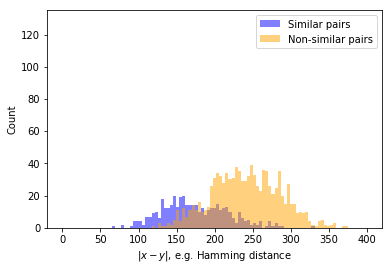

1424/1424 [==============================] - 0s 176us/step
2018-03-06 22:26:10,996 - root - DEBUG - [Iteration = 37] Training Loss = 1.4625554161238994, Testing Loss = 90.30574811902943
2018-03-06 22:26:10,997 - root - DEBUG - Iteration 38 (current beta = 18889465931478580854784)


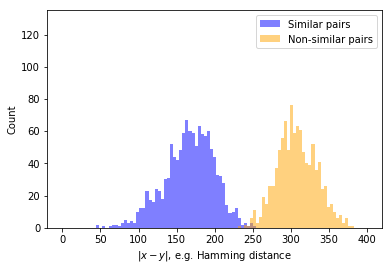

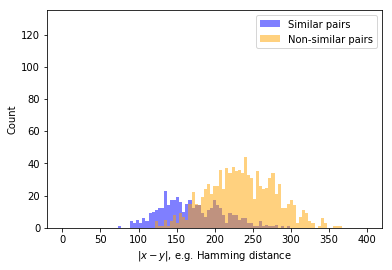

1424/1424 [==============================] - 0s 193us/step
2018-03-06 22:28:13,061 - root - DEBUG - [Iteration = 38] Training Loss = 2.2020287693355955, Testing Loss = 99.68015692515948
2018-03-06 22:28:13,063 - root - DEBUG - Iteration 39 (current beta = 75557863725914323419136)


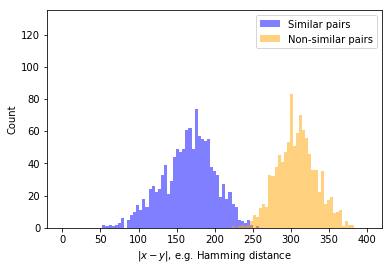

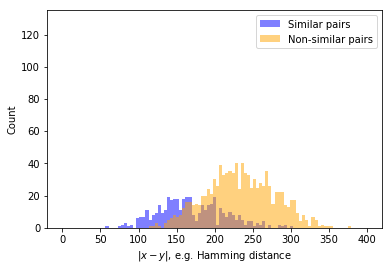

1424/1424 [==============================] - 0s 178us/step
2018-03-06 22:30:15,154 - root - DEBUG - [Iteration = 39] Training Loss = 2.5271216666098364, Testing Loss = 105.31147757504303
2018-03-06 22:30:15,155 - root - DEBUG - Iteration 40 (current beta = 302231454903657293676544)


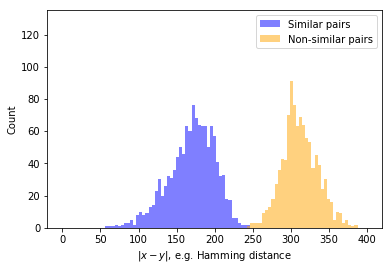

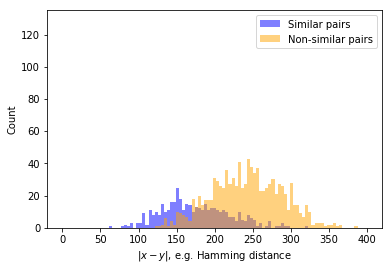

1424/1424 [==============================] - 0s 174us/step
2018-03-06 22:32:17,672 - root - DEBUG - [Iteration = 40] Training Loss = 1.2286637309247552, Testing Loss = 90.15400137107694
2018-03-06 22:32:17,674 - root - DEBUG - Iteration 41 (current beta = 1208925819614629174706176)


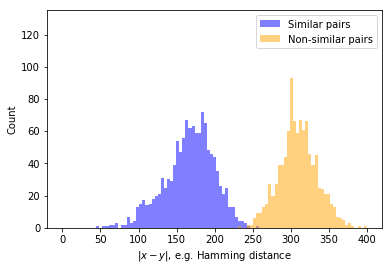

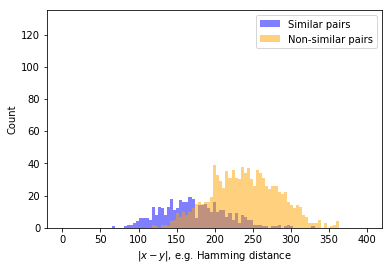

1424/1424 [==============================] - 0s 175us/step
2018-03-06 22:34:19,937 - root - DEBUG - [Iteration = 41] Training Loss = 1.837699828333984, Testing Loss = 93.49227475462837
2018-03-06 22:34:19,938 - root - DEBUG - Iteration 42 (current beta = 4835703278458516698824704)


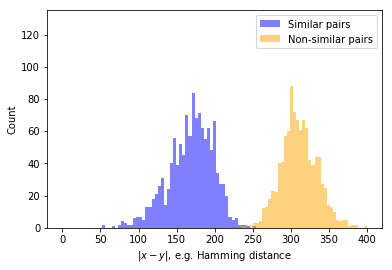

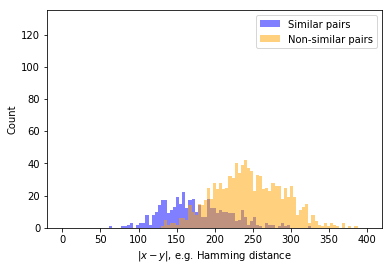

1424/1424 [==============================] - 0s 177us/step
2018-03-06 22:36:22,974 - root - DEBUG - [Iteration = 42] Training Loss = 1.414972384056557, Testing Loss = 85.19500784165739
2018-03-06 22:36:22,976 - root - DEBUG - Iteration 43 (current beta = 19342813113834066795298816)


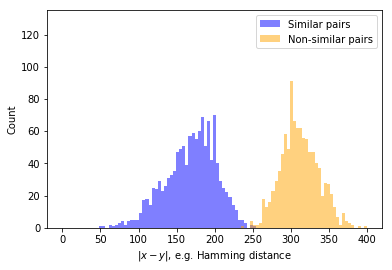

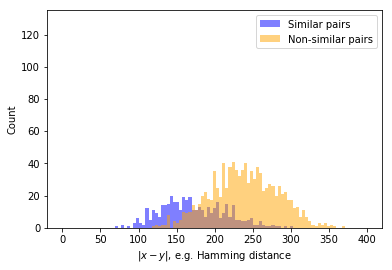

1424/1424 [==============================] - 0s 168us/step
2018-03-06 22:38:25,953 - root - DEBUG - [Iteration = 43] Training Loss = 1.4440161033925427, Testing Loss = 92.52675077459367
2018-03-06 22:38:25,954 - root - DEBUG - Iteration 44 (current beta = 77371252455336267181195264)


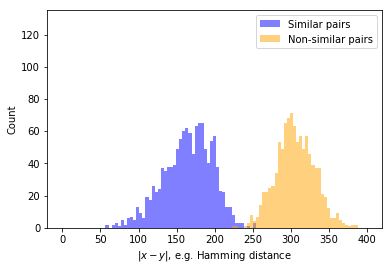

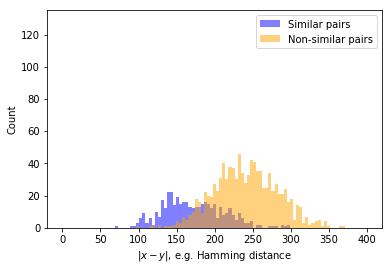

1424/1424 [==============================] - 0s 180us/step
2018-03-06 22:40:29,213 - root - DEBUG - [Iteration = 44] Training Loss = 2.484161594447709, Testing Loss = 87.15340621434571
2018-03-06 22:40:29,214 - root - DEBUG - Iteration 45 (current beta = 309485009821345068724781056)


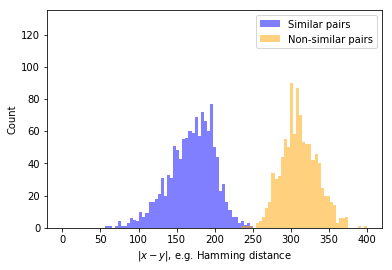

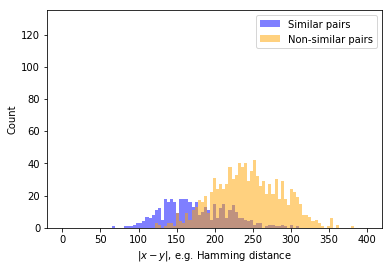

1424/1424 [==============================] - 0s 158us/step
2018-03-06 22:42:32,826 - root - DEBUG - [Iteration = 45] Training Loss = 1.2698046736242208, Testing Loss = 85.13025340421146
2018-03-06 22:42:32,827 - root - DEBUG - Iteration 46 (current beta = 1237940039285380274899124224)


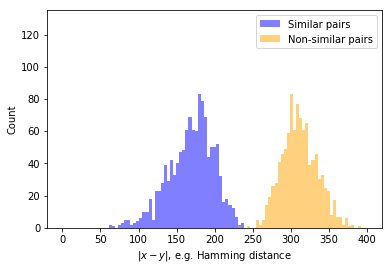

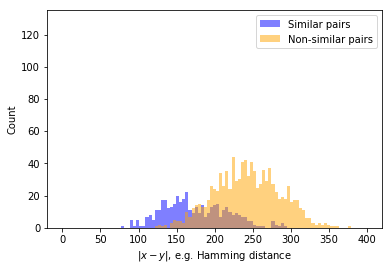

1424/1424 [==============================] - 0s 172us/step
2018-03-06 22:44:36,194 - root - DEBUG - [Iteration = 46] Training Loss = 1.1532875970562255, Testing Loss = 84.38871053103985
2018-03-06 22:44:36,195 - root - DEBUG - Iteration 47 (current beta = 4951760157141521099596496896)


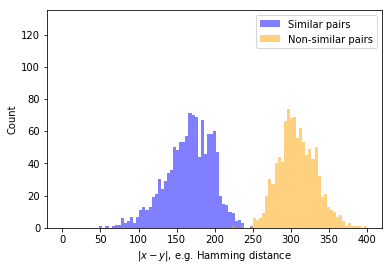

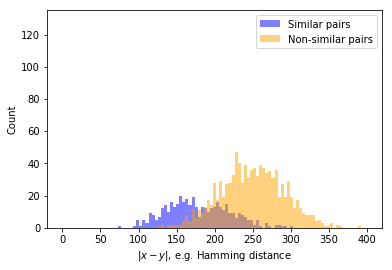

1424/1424 [==============================] - 0s 166us/step
2018-03-06 22:46:39,226 - root - DEBUG - [Iteration = 47] Training Loss = 1.7685771292016517, Testing Loss = 71.22090739966109
2018-03-06 22:46:39,227 - root - DEBUG - Iteration 48 (current beta = 19807040628566084398385987584)


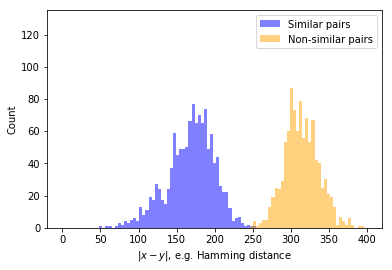

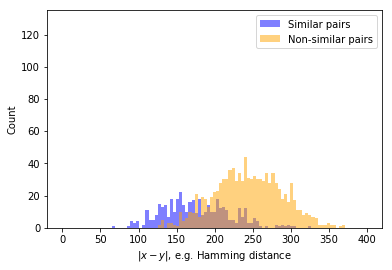

1424/1424 [==============================] - 0s 180us/step
2018-03-06 22:48:42,661 - root - DEBUG - [Iteration = 48] Training Loss = 0.9780836321952926, Testing Loss = 84.94320268276033
2018-03-06 22:48:42,663 - root - DEBUG - Iteration 49 (current beta = 79228162514264337593543950336)


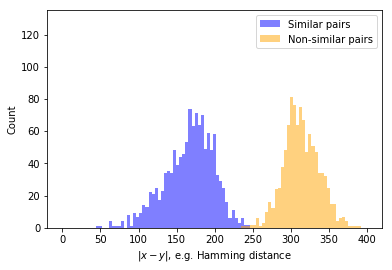

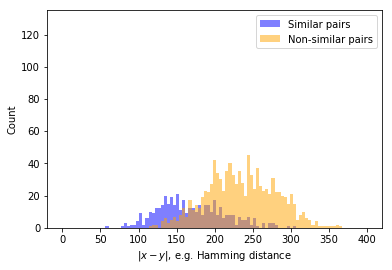

1424/1424 [==============================] - 0s 170us/step
2018-03-06 22:50:46,666 - root - DEBUG - [Iteration = 49] Training Loss = 1.155085777806548, Testing Loss = 102.81875277067839
2018-03-06 22:50:46,667 - root - DEBUG - Iteration 50 (current beta = 316912650057057350374175801344)


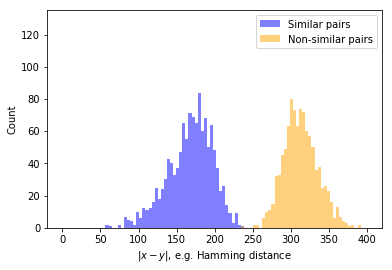

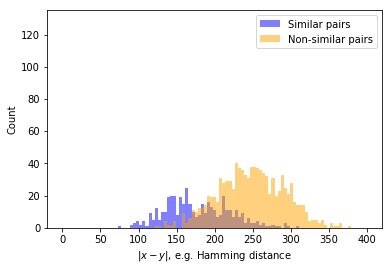

1424/1424 [==============================] - 0s 177us/step
2018-03-06 22:52:50,003 - root - DEBUG - [Iteration = 50] Training Loss = 0.9374258330892519, Testing Loss = 75.37564135736294
2018-03-06 22:52:50,004 - root - DEBUG - Iteration 51 (current beta = 1267650600228229401496703205376)


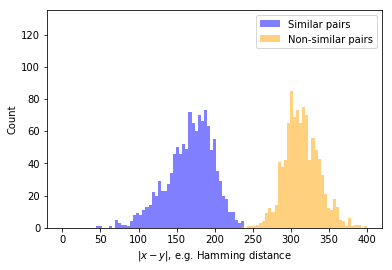

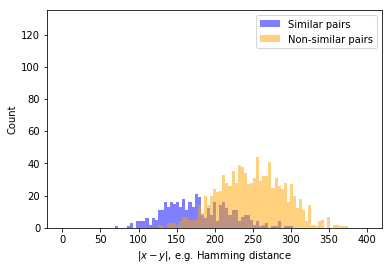

1424/1424 [==============================] - 0s 176us/step
2018-03-06 22:54:53,953 - root - DEBUG - [Iteration = 51] Training Loss = 0.9347543554338394, Testing Loss = 74.63169589722425
2018-03-06 22:54:53,954 - root - DEBUG - Iteration 52 (current beta = 5070602400912917605986812821504)


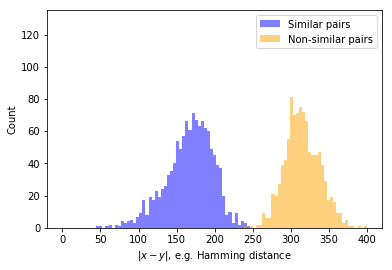

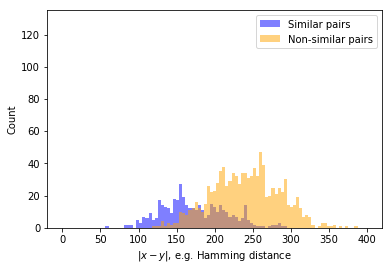

1424/1424 [==============================] - 0s 169us/step
2018-03-06 22:56:57,858 - root - DEBUG - [Iteration = 52] Training Loss = 0.8752671570091496, Testing Loss = 90.03481548949239
2018-03-06 22:56:57,859 - root - DEBUG - Iteration 53 (current beta = 20282409603651670423947251286016)


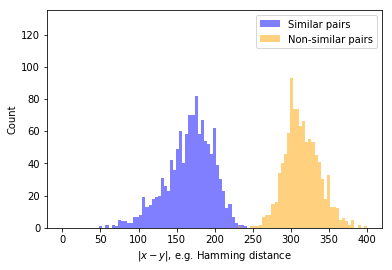

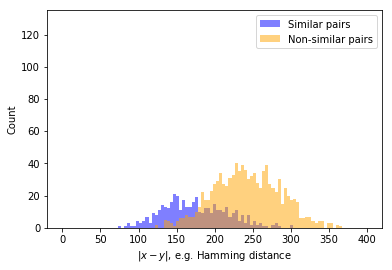

1424/1424 [==============================] - 0s 180us/step
2018-03-06 22:59:01,903 - root - DEBUG - [Iteration = 53] Training Loss = 0.8988737154263177, Testing Loss = 85.9489260536901
2018-03-06 22:59:01,904 - root - DEBUG - Iteration 54 (current beta = 81129638414606681695789005144064)


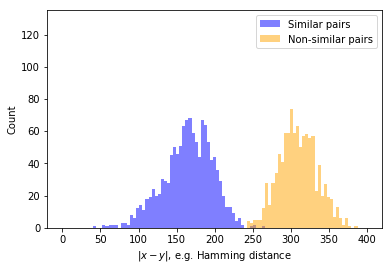

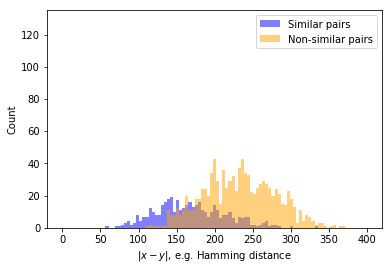

1424/1424 [==============================] - 0s 161us/step
2018-03-06 23:01:05,485 - root - DEBUG - [Iteration = 54] Training Loss = 1.7995672850047841, Testing Loss = 111.24312151704778
2018-03-06 23:01:05,486 - root - DEBUG - Iteration 55 (current beta = 324518553658426726783156020576256)


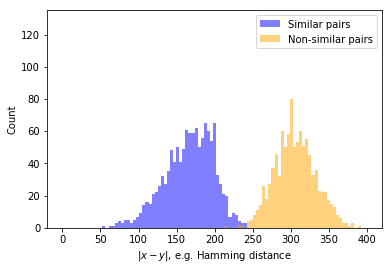

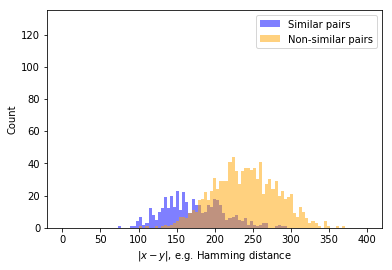

1424/1424 [==============================] - 0s 176us/step
2018-03-06 23:03:08,918 - root - DEBUG - [Iteration = 55] Training Loss = 2.7995604094235875, Testing Loss = 89.07087327581777
2018-03-06 23:03:08,919 - root - DEBUG - Iteration 56 (current beta = 1298074214633706907132624082305024)


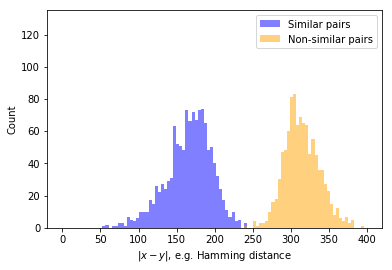

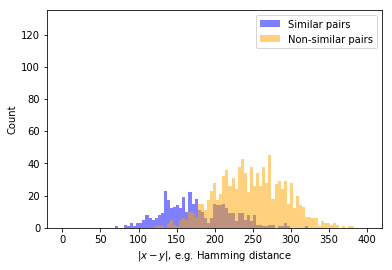

1424/1424 [==============================] - 0s 203us/step
2018-03-06 23:05:12,683 - root - DEBUG - [Iteration = 56] Training Loss = 0.8446458473599334, Testing Loss = 78.74419613919231
2018-03-06 23:05:12,684 - root - DEBUG - Iteration 57 (current beta = 5192296858534827628530496329220096)


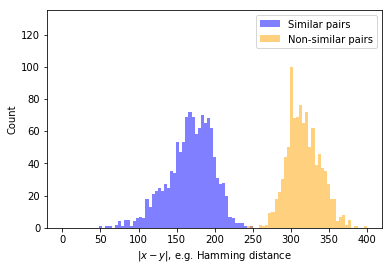

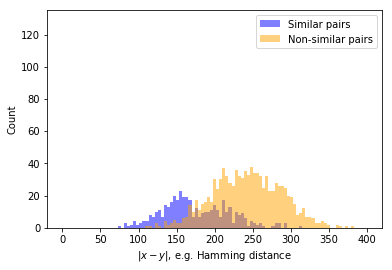

1424/1424 [==============================] - 0s 179us/step
2018-03-06 23:07:16,905 - root - DEBUG - [Iteration = 57] Training Loss = 0.6463010590928038, Testing Loss = 87.59278057038449
2018-03-06 23:07:16,906 - root - DEBUG - Iteration 58 (current beta = 20769187434139310514121985316880384)


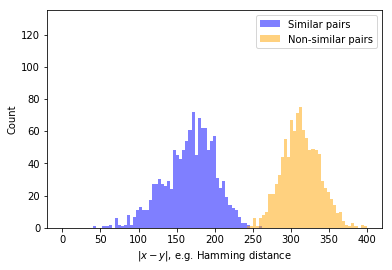

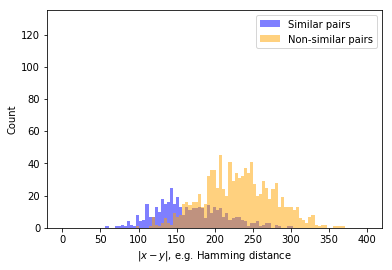

1424/1424 [==============================] - 0s 179us/step
2018-03-06 23:09:19,554 - root - DEBUG - [Iteration = 58] Training Loss = 1.3654463649807473, Testing Loss = 112.29081628015369
2018-03-06 23:09:19,555 - root - DEBUG - Iteration 59 (current beta = 83076749736557242056487941267521536)


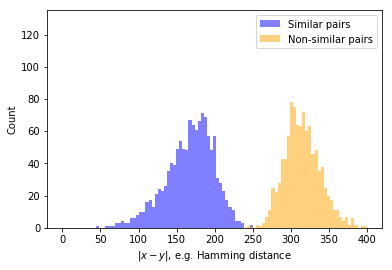

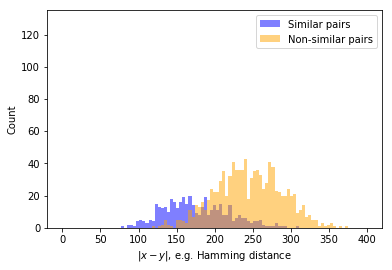

1424/1424 [==============================] - 0s 185us/step
2018-03-06 23:11:22,012 - root - DEBUG - [Iteration = 59] Training Loss = 0.8618940474086217, Testing Loss = 81.16257504022188
2018-03-06 23:11:22,014 - root - DEBUG - Iteration 60 (current beta = 332306998946228968225951765070086144)


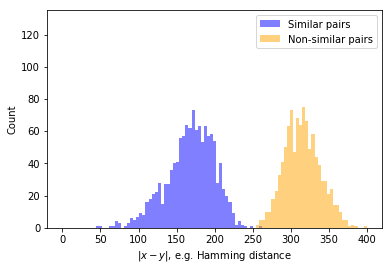

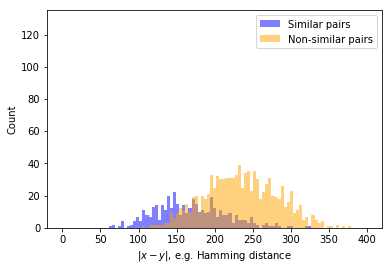

1424/1424 [==============================] - 0s 180us/step
2018-03-06 23:13:24,738 - root - DEBUG - [Iteration = 60] Training Loss = 0.8960385773684914, Testing Loss = 108.08249466183983
2018-03-06 23:13:24,740 - root - DEBUG - Iteration 61 (current beta = 1329227995784915872903807060280344576)


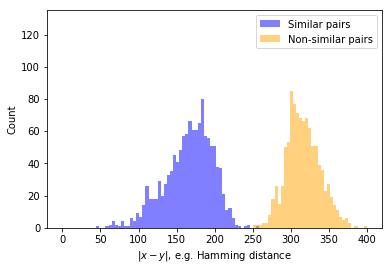

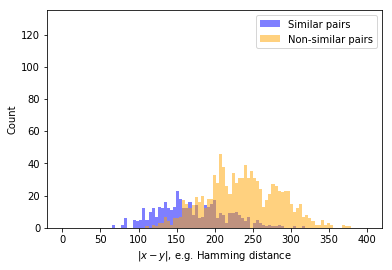

1424/1424 [==============================] - 0s 183us/step
2018-03-06 23:15:27,423 - root - DEBUG - [Iteration = 61] Training Loss = 0.7429169240512999, Testing Loss = 103.54610399043794
2018-03-06 23:15:27,424 - root - DEBUG - Iteration 62 (current beta = 5316911983139663491615228241121378304)


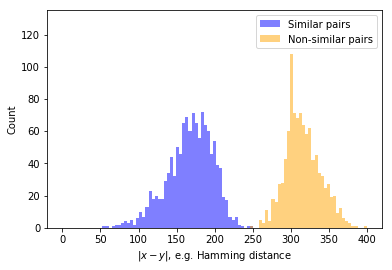

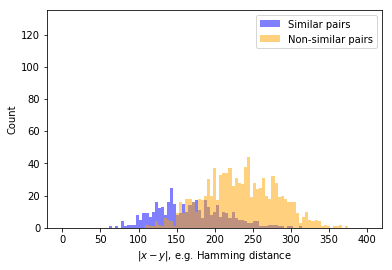

1424/1424 [==============================] - 0s 181us/step
2018-03-06 23:17:30,388 - root - DEBUG - [Iteration = 62] Training Loss = 0.7800030705514807, Testing Loss = 107.4565169863361
2018-03-06 23:17:30,389 - root - DEBUG - Iteration 63 (current beta = 21267647932558653966460912964485513216)


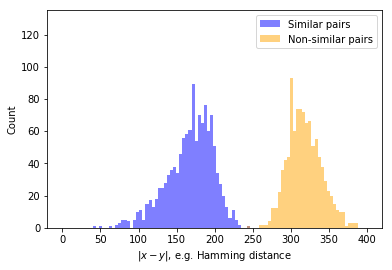

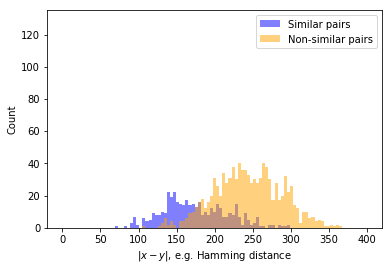

1424/1424 [==============================] - 0s 178us/step
2018-03-06 23:19:33,660 - root - DEBUG - [Iteration = 63] Training Loss = 0.5677898465963376, Testing Loss = 83.6934270965919
2018-03-06 23:19:33,661 - root - DEBUG - Iteration 64 (current beta = 85070591730234615865843651857942052864)


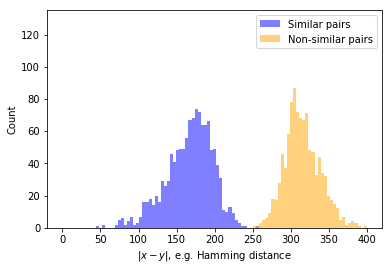

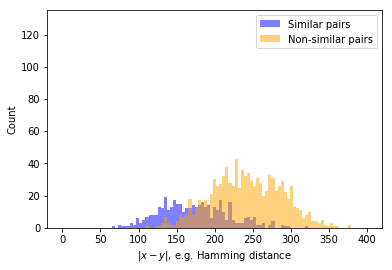

1424/1424 [==============================] - 0s 180us/step
2018-03-06 23:21:36,158 - root - DEBUG - [Iteration = 64] Training Loss = 0.7749978988149048, Testing Loss = 91.74310612025556
2018-03-06 23:21:36,160 - root - DEBUG - Iteration 65 (current beta = 340282366920938463463374607431768211456)


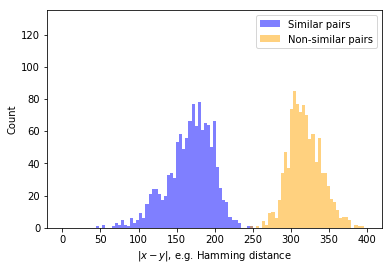

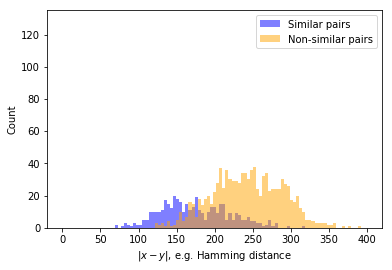

1424/1424 [==============================] - 0s 183us/step
2018-03-06 23:23:38,684 - root - DEBUG - [Iteration = 65] Training Loss = 0.5600087530186139, Testing Loss = 88.253213761479
2018-03-06 23:23:38,685 - root - DEBUG - Iteration 66 (current beta = 1361129467683753853853498429727072845824)


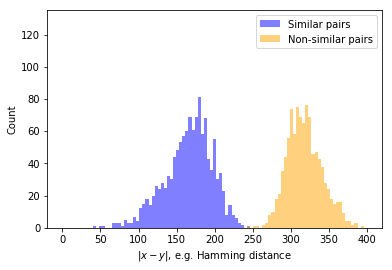

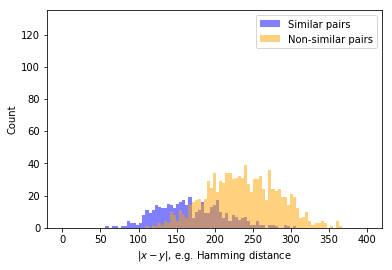

1424/1424 [==============================] - 0s 182us/step
2018-03-06 23:25:42,596 - root - DEBUG - [Iteration = 66] Training Loss = 0.6405958637258047, Testing Loss = 101.87467834579476
2018-03-06 23:25:42,597 - root - DEBUG - Iteration 67 (current beta = 5444517870735015415413993718908291383296)


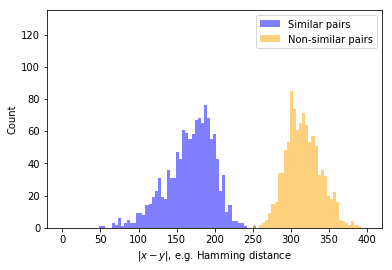

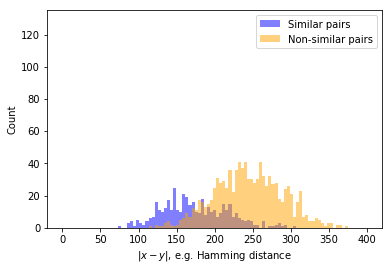

1424/1424 [==============================] - 0s 176us/step
2018-03-06 23:27:46,951 - root - DEBUG - [Iteration = 67] Training Loss = 0.7236713577112461, Testing Loss = 83.6656784711594
2018-03-06 23:27:46,952 - root - DEBUG - Iteration 68 (current beta = 21778071482940061661655974875633165533184)


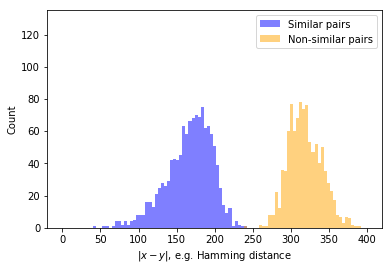

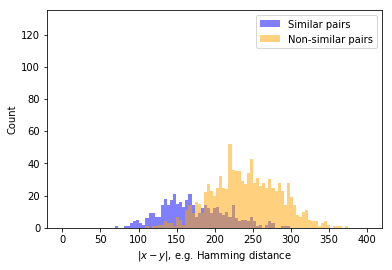

1424/1424 [==============================] - 0s 185us/step
2018-03-06 23:29:49,631 - root - DEBUG - [Iteration = 68] Training Loss = 0.5399664284939545, Testing Loss = 90.9563358847596
2018-03-06 23:29:49,632 - root - DEBUG - Iteration 69 (current beta = 87112285931760246646623899502532662132736)


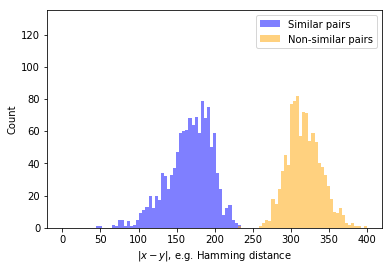

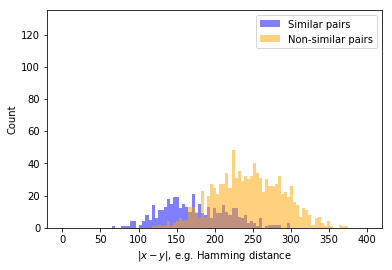

1424/1424 [==============================] - 0s 184us/step
2018-03-06 23:31:52,463 - root - DEBUG - [Iteration = 69] Training Loss = 0.6450909669869221, Testing Loss = 83.51725053674217
2018-03-06 23:31:52,464 - root - DEBUG - Iteration 70 (current beta = 348449143727040986586495598010130648530944)


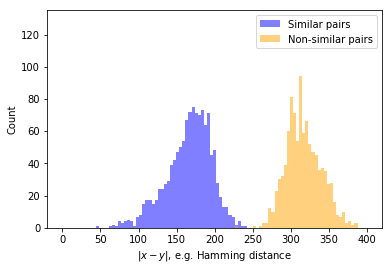

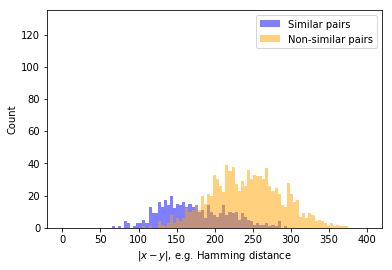

1424/1424 [==============================] - 0s 185us/step
2018-03-06 23:33:55,800 - root - DEBUG - [Iteration = 70] Training Loss = 0.7102867080395983, Testing Loss = 91.56571885696455
2018-03-06 23:33:55,801 - root - DEBUG - Iteration 71 (current beta = 1393796574908163946345982392040522594123776)


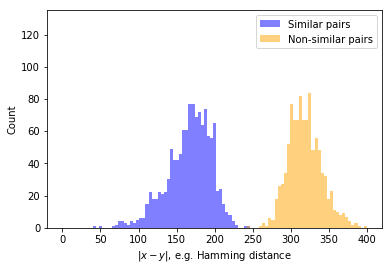

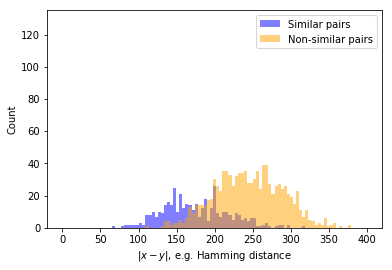

1424/1424 [==============================] - 0s 181us/step
2018-03-06 23:35:58,277 - root - DEBUG - [Iteration = 71] Training Loss = 0.5198492410158679, Testing Loss = 83.3544517136859
2018-03-06 23:35:58,278 - root - DEBUG - Iteration 72 (current beta = 5575186299632655785383929568162090376495104)


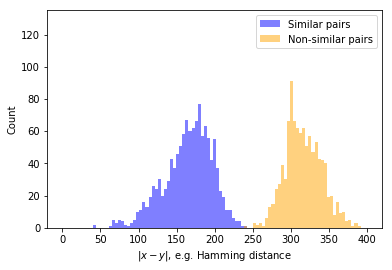

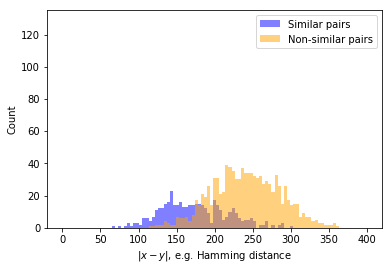

1424/1424 [==============================] - 0s 183us/step
2018-03-06 23:38:00,599 - root - DEBUG - [Iteration = 72] Training Loss = 0.8633143429033358, Testing Loss = 89.97640647169914
2018-03-06 23:38:00,600 - root - DEBUG - Iteration 73 (current beta = 22300745198530623141535718272648361505980416)


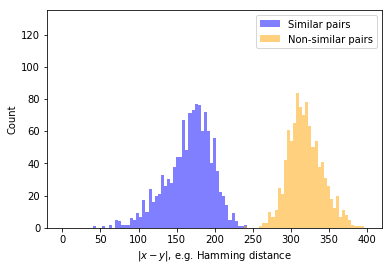

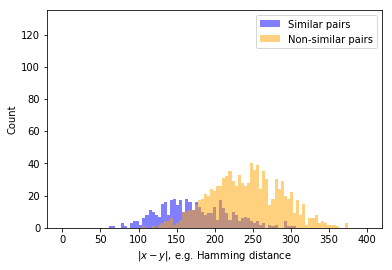

1424/1424 [==============================] - 0s 183us/step
2018-03-06 23:40:04,314 - root - DEBUG - [Iteration = 73] Training Loss = 0.5655597441808671, Testing Loss = 92.74014464774159
2018-03-06 23:40:04,315 - root - DEBUG - Iteration 74 (current beta = 89202980794122492566142873090593446023921664)


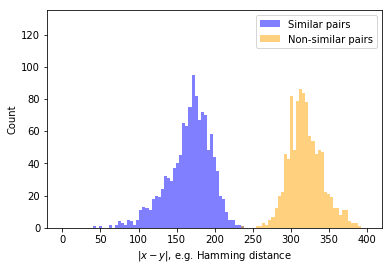

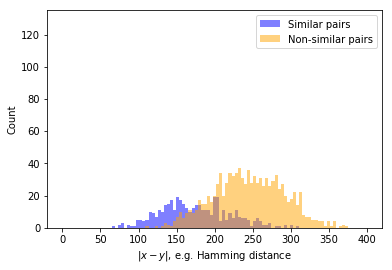

1424/1424 [==============================] - 0s 176us/step
2018-03-06 23:42:07,783 - root - DEBUG - [Iteration = 74] Training Loss = 0.5321643700359634, Testing Loss = 85.209414145543
2018-03-06 23:42:07,785 - root - DEBUG - Iteration 75 (current beta = 356811923176489970264571492362373784095686656)


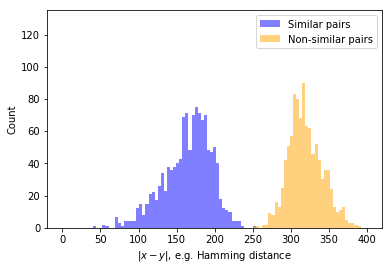

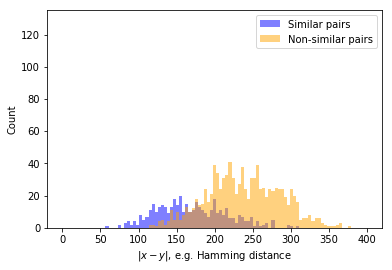

1424/1424 [==============================] - 0s 182us/step
2018-03-06 23:44:11,403 - root - DEBUG - [Iteration = 75] Training Loss = 0.540091878642661, Testing Loss = 102.13581237522362
2018-03-06 23:44:11,404 - root - DEBUG - Iteration 76 (current beta = 1427247692705959881058285969449495136382746624)


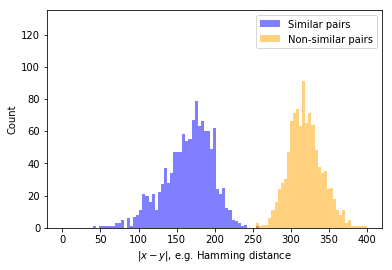

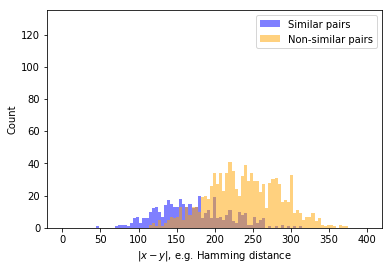

1424/1424 [==============================] - 0s 181us/step
2018-03-06 23:46:15,102 - root - DEBUG - [Iteration = 76] Training Loss = 0.5682895784750918, Testing Loss = 101.24902178755218
2018-03-06 23:46:15,103 - root - DEBUG - Iteration 77 (current beta = 5708990770823839524233143877797980545530986496)


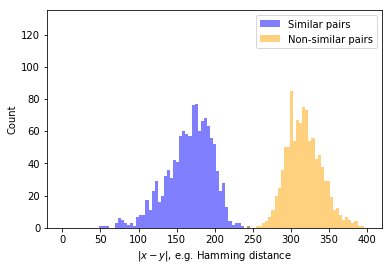

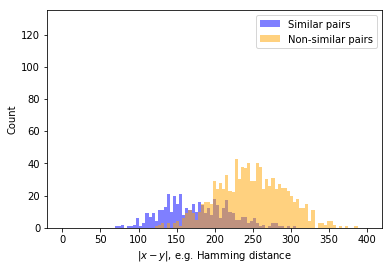

1424/1424 [==============================] - 0s 203us/step
2018-03-06 23:48:18,582 - root - DEBUG - [Iteration = 77] Training Loss = 0.623738580331948, Testing Loss = 78.05851653435927
2018-03-06 23:48:18,583 - root - DEBUG - Iteration 78 (current beta = 22835963083295358096932575511191922182123945984)


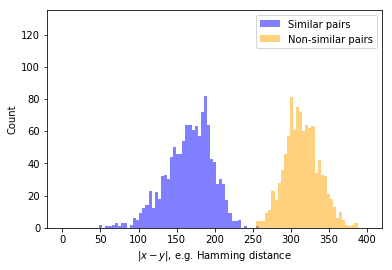

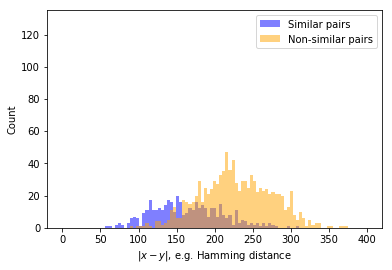

1424/1424 [==============================] - 0s 167us/step
2018-03-06 23:50:21,985 - root - DEBUG - [Iteration = 78] Training Loss = 0.8507198476076665, Testing Loss = 119.27379023780775
2018-03-06 23:50:21,986 - root - DEBUG - Iteration 79 (current beta = 91343852333181432387730302044767688728495783936)


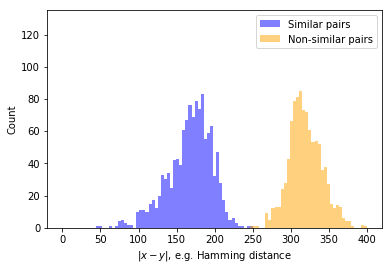

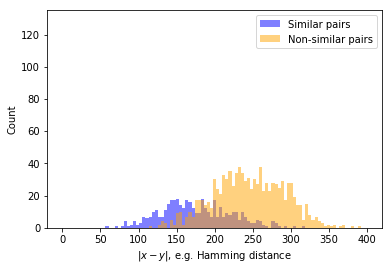

1424/1424 [==============================] - 0s 182us/step
2018-03-06 23:52:25,581 - root - DEBUG - [Iteration = 79] Training Loss = 0.5497301191293815, Testing Loss = 86.013933077036
2018-03-06 23:52:25,582 - root - DEBUG - Iteration 80 (current beta = 365375409332725729550921208179070754913983135744)


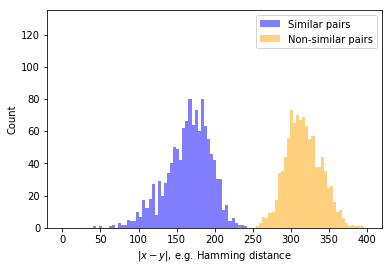

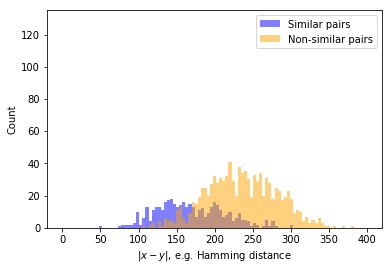

1424/1424 [==============================] - 0s 202us/step
2018-03-06 23:54:29,404 - root - DEBUG - [Iteration = 80] Training Loss = 0.7715209670988548, Testing Loss = 103.84799036576172
2018-03-06 23:54:29,405 - root - DEBUG - Iteration 81 (current beta = 1461501637330902918203684832716283019655932542976)


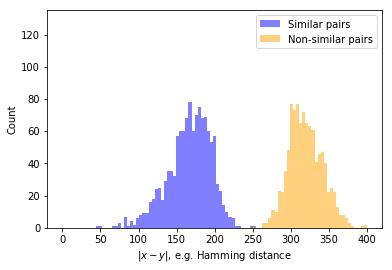

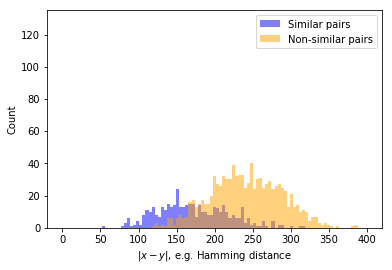

1424/1424 [==============================] - 0s 185us/step
2018-03-06 23:56:33,834 - root - DEBUG - [Iteration = 81] Training Loss = 0.5047643404310712, Testing Loss = 93.86073467386572
2018-03-06 23:56:33,836 - root - DEBUG - Iteration 82 (current beta = 5846006549323611672814739330865132078623730171904)


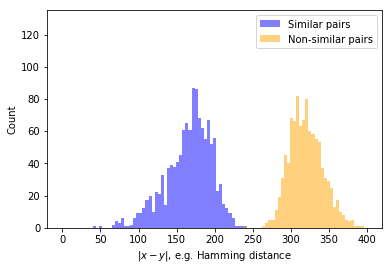

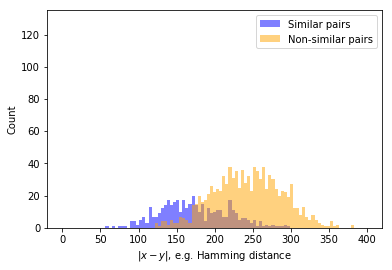

1424/1424 [==============================] - 0s 174us/step
2018-03-06 23:58:37,875 - root - DEBUG - [Iteration = 82] Training Loss = 0.46663614763663364, Testing Loss = 88.3139975682487
2018-03-06 23:58:37,877 - root - DEBUG - Iteration 83 (current beta = 23384026197294446691258957323460528314494920687616)


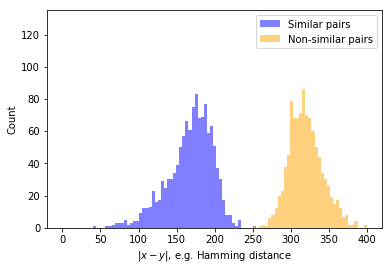

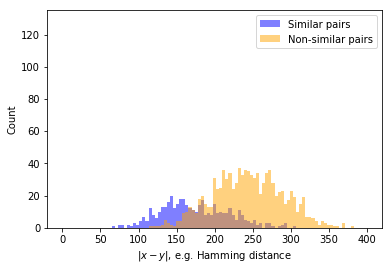

1424/1424 [==============================] - 0s 179us/step
2018-03-07 00:00:41,887 - root - DEBUG - [Iteration = 83] Training Loss = 0.4649001854172659, Testing Loss = 87.65821434967638
2018-03-07 00:00:41,888 - root - DEBUG - Iteration 84 (current beta = 93536104789177786765035829293842113257979682750464)


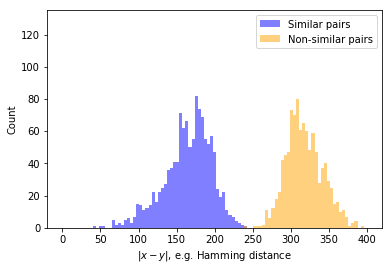

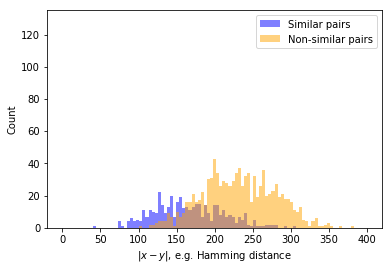

1424/1424 [==============================] - 0s 175us/step
2018-03-07 00:02:45,686 - root - DEBUG - [Iteration = 84] Training Loss = 0.7045341157822183, Testing Loss = 112.430682347041
2018-03-07 00:02:45,688 - root - DEBUG - Iteration 85 (current beta = 374144419156711147060143317175368453031918731001856)


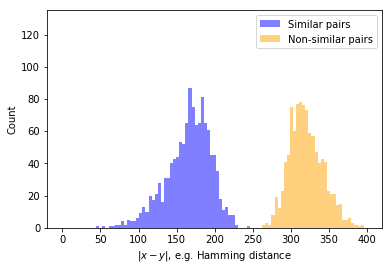

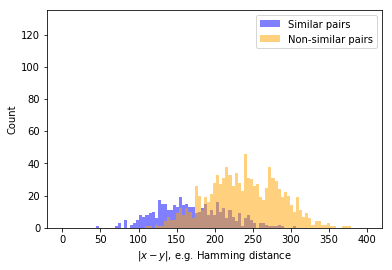

1424/1424 [==============================] - 0s 178us/step
2018-03-07 00:04:49,446 - root - DEBUG - [Iteration = 85] Training Loss = 0.4561645079016416, Testing Loss = 98.9039819557429
2018-03-07 00:04:49,447 - root - DEBUG - Iteration 86 (current beta = 1496577676626844588240573268701473812127674924007424)


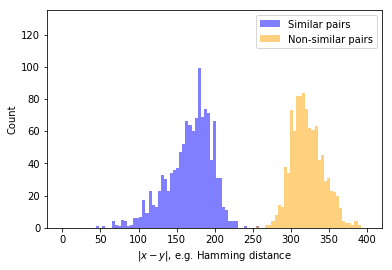

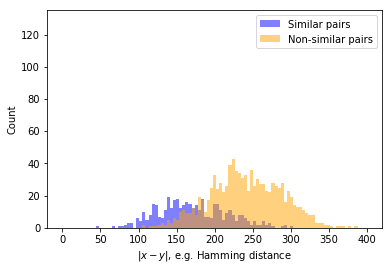

1424/1424 [==============================] - 0s 186us/step
2018-03-07 00:06:53,688 - root - DEBUG - [Iteration = 86] Training Loss = 0.3534167426566665, Testing Loss = 93.19950611078379
2018-03-07 00:06:53,690 - root - DEBUG - Iteration 87 (current beta = 5986310706507378352962293074805895248510699696029696)


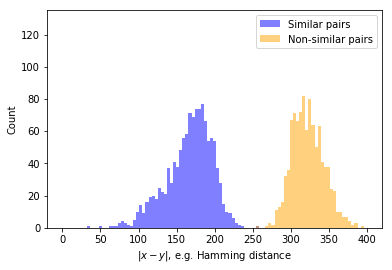

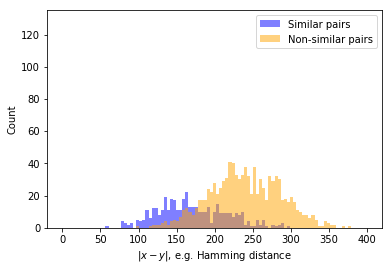

1424/1424 [==============================] - 0s 180us/step
2018-03-07 00:08:58,823 - root - DEBUG - [Iteration = 87] Training Loss = 0.3498127050478669, Testing Loss = 95.20355153630038
2018-03-07 00:08:58,824 - root - DEBUG - Iteration 88 (current beta = 23945242826029513411849172299223580994042798784118784)


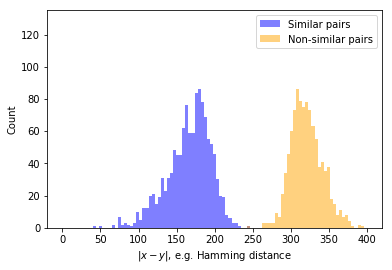

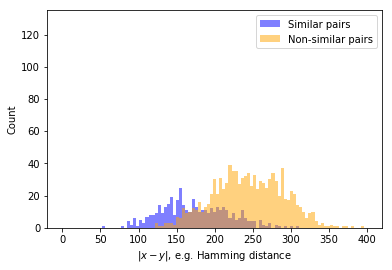

1424/1424 [==============================] - 0s 190us/step
2018-03-07 00:11:03,282 - root - DEBUG - [Iteration = 88] Training Loss = 0.4010090283847233, Testing Loss = 86.61746773083976
2018-03-07 00:11:03,283 - root - DEBUG - Iteration 89 (current beta = 95780971304118053647396689196894323976171195136475136)


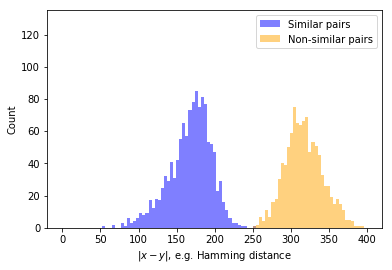

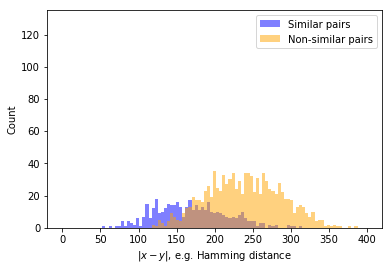

1424/1424 [==============================] - 0s 184us/step
2018-03-07 00:13:07,410 - root - DEBUG - [Iteration = 89] Training Loss = 0.7971697375962166, Testing Loss = 100.29087983404568
2018-03-07 00:13:07,411 - root - DEBUG - Iteration 90 (current beta = 383123885216472214589586756787577295904684780545900544)


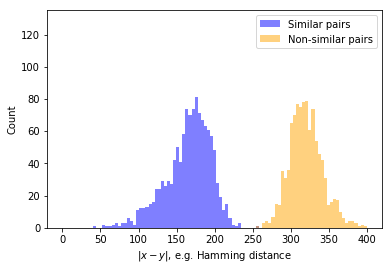

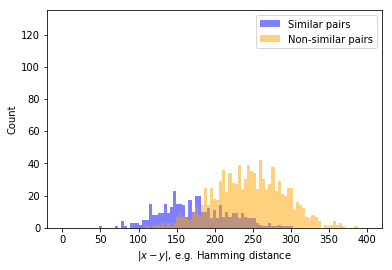

1424/1424 [==============================] - 0s 180us/step
2018-03-07 00:15:11,976 - root - DEBUG - [Iteration = 90] Training Loss = 0.45780485610886396, Testing Loss = 83.20343559147435
2018-03-07 00:15:11,978 - root - DEBUG - Iteration 91 (current beta = 1532495540865888858358347027150309183618739122183602176)


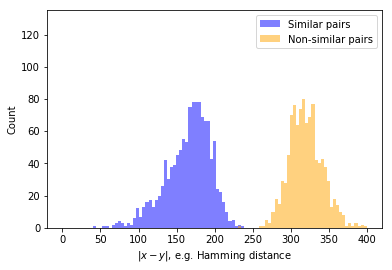

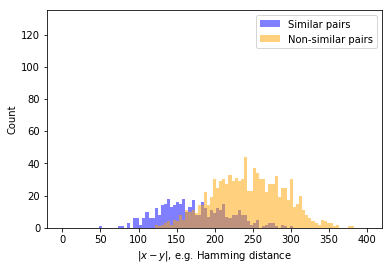

1424/1424 [==============================] - 0s 192us/step
2018-03-07 00:17:17,262 - root - DEBUG - [Iteration = 91] Training Loss = 0.4995025920382452, Testing Loss = 86.47561203468632
2018-03-07 00:17:17,264 - root - DEBUG - Iteration 92 (current beta = 6129982163463555433433388108601236734474956488734408704)


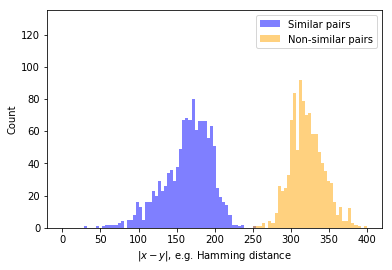

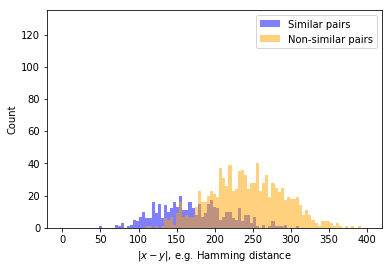

1424/1424 [==============================] - 0s 178us/step
2018-03-07 00:19:20,986 - root - DEBUG - [Iteration = 92] Training Loss = 0.4373892865594628, Testing Loss = 93.24809902459592
2018-03-07 00:19:20,987 - root - DEBUG - Iteration 93 (current beta = 24519928653854221733733552434404946937899825954937634816)


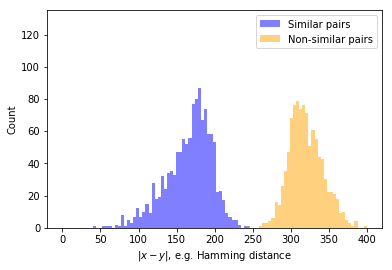

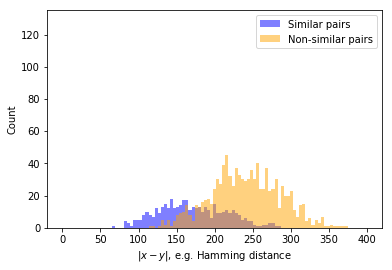

1424/1424 [==============================] - 0s 180us/step
2018-03-07 00:21:24,922 - root - DEBUG - [Iteration = 93] Training Loss = 0.4921139372074429, Testing Loss = 91.41492736353173
2018-03-07 00:21:24,923 - root - DEBUG - Iteration 94 (current beta = 98079714615416886934934209737619787751599303819750539264)


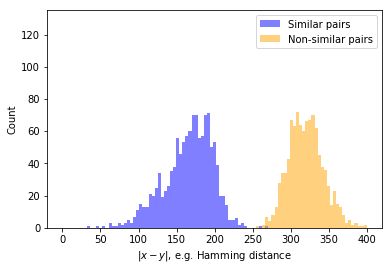

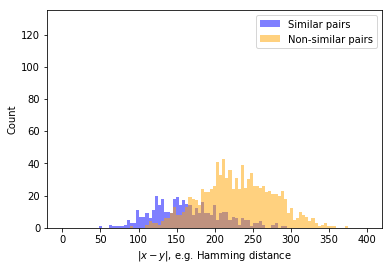

1424/1424 [==============================] - 0s 177us/step
2018-03-07 00:23:28,887 - root - DEBUG - [Iteration = 94] Training Loss = 0.5957968553991744, Testing Loss = 117.6194490665999
2018-03-07 00:23:28,888 - root - DEBUG - Iteration 95 (current beta = 392318858461667547739736838950479151006397215279002157056)


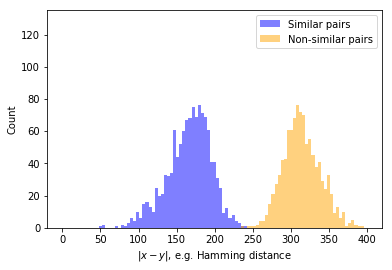

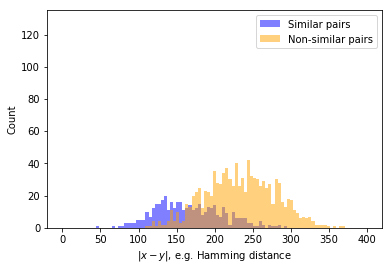

1424/1424 [==============================] - 0s 173us/step
2018-03-07 00:25:33,011 - root - DEBUG - [Iteration = 95] Training Loss = 0.9733016430994504, Testing Loss = 106.11875253713826
2018-03-07 00:25:33,013 - root - DEBUG - Iteration 96 (current beta = 1569275433846670190958947355801916604025588861116008628224)


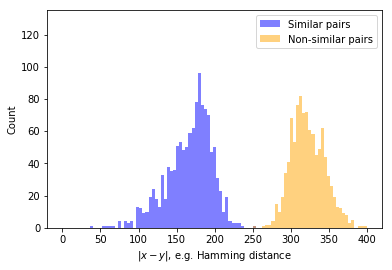

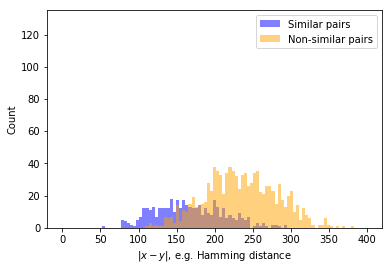

1424/1424 [==============================] - 0s 183us/step
2018-03-07 00:27:37,047 - root - DEBUG - [Iteration = 96] Training Loss = 0.36821886399229864, Testing Loss = 105.19876078958885
2018-03-07 00:27:37,048 - root - DEBUG - Iteration 97 (current beta = 6277101735386680763835789423207666416102355444464034512896)


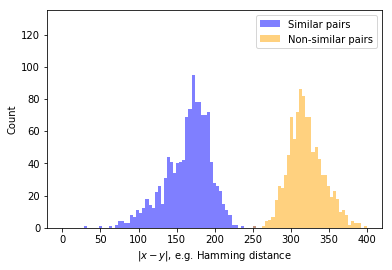

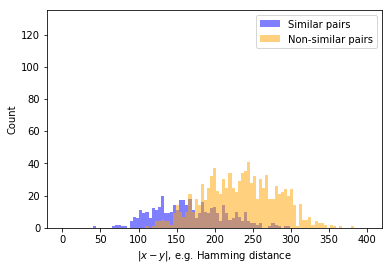

1424/1424 [==============================] - 0s 180us/step
2018-03-07 00:29:41,089 - root - DEBUG - [Iteration = 97] Training Loss = 0.45852447800692253, Testing Loss = 106.27368133936831
2018-03-07 00:29:41,091 - root - DEBUG - Iteration 98 (current beta = 25108406941546723055343157692830665664409421777856138051584)


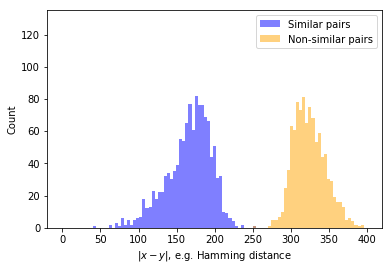

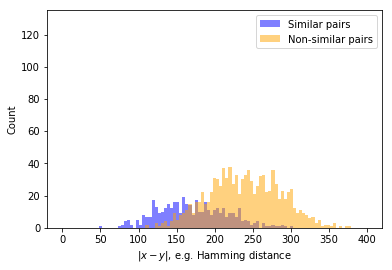

1424/1424 [==============================] - 0s 178us/step
2018-03-07 00:31:44,930 - root - DEBUG - [Iteration = 98] Training Loss = 0.28700104242030583, Testing Loss = 97.07806671128263
2018-03-07 00:31:44,932 - root - DEBUG - Iteration 99 (current beta = 100433627766186892221372630771322662657637687111424552206336)


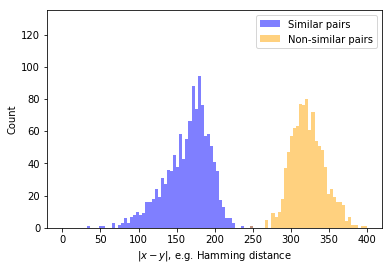

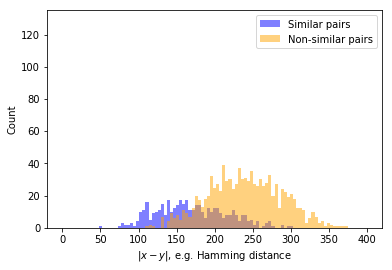

1424/1424 [==============================] - 0s 177us/step
2018-03-07 00:33:48,483 - root - DEBUG - [Iteration = 99] Training Loss = 0.3687742265758876, Testing Loss = 96.40856646591526
2018-03-07 00:33:48,485 - root - DEBUG - Iteration 100 (current beta = 401734511064747568885490523085290650630550748445698208825344)


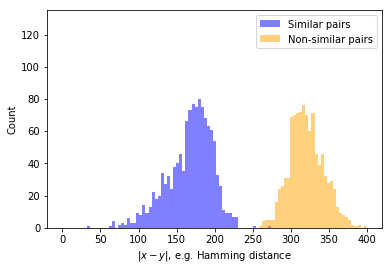

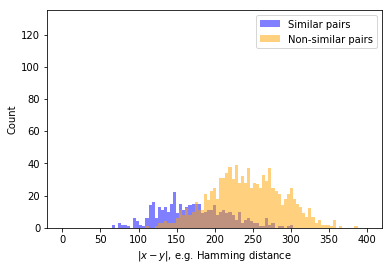

1424/1424 [==============================] - 0s 186us/step
2018-03-07 00:35:54,026 - root - DEBUG - [Iteration = 100] Training Loss = 0.5077644192542021, Testing Loss = 91.44737477175724


In [34]:
for m in range(1, number_of_iterations+1):
    logger.debug("Iteration {:} (current beta = {:})".format(m, beta))
    
    # Train a model with 4 inputs and 1 dummy output.
    model.fit({'image_1': X1, 'image_2': X2, 'similarity': S, 'weight': W}, [S], verbose=verbose, epochs=number_of_epochs)
    beta *= beta_factor
    
    representation_model = Model(image_a, encoded_a)
    visualize(X1, X2, groundTruth, representation_model)
    visualize(X1_val, X2_val, groundTruth_val, representation_model)
#     visualizeFilters()
    
    train_loss = model.evaluate({'image_1': X1, 'image_2': X2, 'similarity': S, 'weight': W}, [S])
    test_loss  = model.evaluate({'image_1': X1_val, 'image_2': X2_val, 'similarity': S_val, 'weight': W_val}, [S_val])
    logger.debug("[Iteration = {:}] Training Loss = {:}, Testing Loss = {:}".format(m, train_loss, test_loss))
    train_losses.append(train_loss)
    test_losses.append(test_loss)

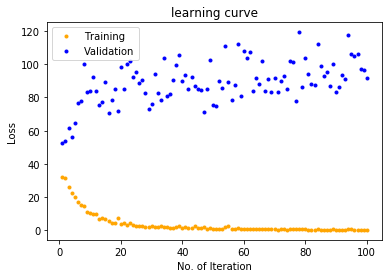

In [35]:
plt.figure()
plt.title("learning curve")
plt.plot(range(1,len(train_losses)+1), train_losses, '.', color='orange', label='Training')
plt.plot(range(1,len(test_losses)+1), test_losses, '.', color='blue', label='Validation')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("No. of Iteration")
plt.show()

In [ ]:
visualizeFilters()

## Save Model

In [36]:
MODEL_NAME = str(datetime.date.today()) + EXPERIMENT_NAME + "[Iteration={:}]".format(number_of_iterations)
logger.debug("Save model to {:}.h5".format(MODEL_NAME))
model.save(MODEL_NAME + ".h5")

2018-03-07 00:35:55,406 - root - DEBUG - Save model to 2018-03-07[HashNet-100-iteration][Iteration=100].h5


## Visualize Performance 

__Obtain a representation model__

This representation model is the same as the trained model above without the loss layer at the very end.

In [37]:
representation_model = Model(image_a, encoded_a)

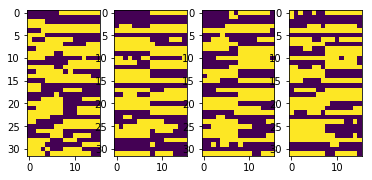

In [38]:
# Get sample output
# Reshaped to be (32,16) for visualization purposes.
pred_X1 = representation_model.predict(X1)
plt.subplot(1,4,1)
plt.imshow(pred_X1[:1].reshape(32,16) > 0)
plt.subplot(1,4,2)
plt.imshow(pred_X1[1:2].reshape(32,16) > 0)
plt.subplot(1,4,3)
plt.imshow(pred_X1[2:3].reshape(32,16) > 0)
plt.subplot(1,4,4)
plt.imshow(pred_X1[3:4].reshape(32,16) > 0)
plt.show()

## Evaluate Performance
Calculate the hamming distance input pairs and plot the corresponding histogram.

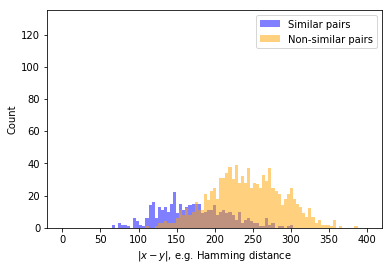

In [39]:
representation_model = Model(image_a, encoded_a)
visualize(X1_val, X2_val, groundTruth_val, representation_model)

## Appendix: Architecture Details

In [40]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_1 (InputLayer)            (None, 1, 76, 121)   0                                            
__________________________________________________________________________________________________
image_2 (InputLayer)            (None, 1, 76, 121)   0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 8, 1)     175360      image_1[0][0]                    
                                                                 image_2[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 512)          0           sequential_1[1][0]               
__________

In [41]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 12, 1)         154880    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 12, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 8, 1)          20480     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 8, 1)          0         
Total params: 175,360
Trainable params: 175,360
Non-trainable params: 0
_________________________________________________________________


In [42]:
visualizeLayer()